# DATA 608 W2020 - FINAL PROJECT

Frederick Li, Szabolcs Szokoly

### Introduction

This Jupyter Notebook file will walk the reader through the data exploration and big data analysis methods used on the Yellow Taxicab dataset provided by the Taxi & Limousine Commission (TLC) of New York City (NYC).

The Yellow Taxicab service of NYC represents a significant portion of travel and commuting in the city, with hundreds of thousands of trips per day, and millions of trips per month. Although Uber has overtaken the NYC Yellow Taxicab service in number of trips dispatched by 2018, the taxicab service still holds a non-insignificant share of the ride service market. As such, it is still important for NYC taxicab drivers/service providers to understand the patterns of trip pickups/dropoffs to maximize potential profit.

This project aims to analyze the 2019 Yellow Taxicab dataset provided by the TLC, and determine what patterns and trends there are in regards to taxi trips. Afterwards, we will create a machine learning model that aims to predict the profitability of a trip based on certain parameters.

The original plan was to use the Databricks clusters however due to the size of this dataset and the very limited resources available on Databricks community edition clusters we soon realized we were not going to have enough time to complete this project if we remained on the Databricks platform. We switched to TALC.

In [1]:
# kill previous sparkcluster jobs just in case
try:
    sc.stop()
except:
    pass
try:
    sj.stop()
except:
    pass

! scancel -u `whoami` -n sparkcluster

### Instantiating Spark interface

In [2]:
import os, atexit, sys, urllib
import calendar
import time
import findspark, sparkhpc, pyspark
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
import zipfile

try:
    import geopandas as gpd
    import imageio
    import contextily as ctx
    import shapely
    shapely.speedups.enable()
    from shapely.geometry import Point, Polygon, shape
except:
    pass

from matplotlib.ticker import FuncFormatter
from datetime import date
from pyspark.context import SparkContext
from pyspark.sql import SQLContext, Window
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import *
from glob import glob
from IPython.display import Image
from IPython.display import HTML

In [3]:
findspark.init()

# specify your partition (unless you're OK with default)
#os.environ['SBATCH_PARTITION']='cpu24'
NCORES = 16

sj = sparkhpc.sparkjob.sparkjob(
    ncores = NCORES,                   # total number or cores
    cores_per_executor = 4,            # parallelism of a single executor
    memory_per_core = 15240,           # memory per core in MB 
    walltime = "2:0"                   # hh:mm format
)

sj.wait_to_start()
sc = sj.start_spark()
scq = SQLContext(sc)

def exitHandler(sj,sc):
    try:
        print('Trapped Exit cleaning up Spark Context')
        sc.stop()
    except:
        pass
    try:
        print('Trapped Exit cleaning up Spark Job')
        sj.stop()
    except:
        pass

atexit.register(exitHandler, sj, sc)
sc

INFO:sparkhpc.sparkjob:Submitted batch job 8338

INFO:sparkhpc.sparkjob:Submitted cluster 0


<SparkContext master=spark://b11:7078 appName=pyspark-shell>

### Description of the Datasets

The dataset is provided by the New York City's (NYC) Trip & Limousine Commission (TLC) here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

The data are provided on a monthly basis, and span from Jan. 2009 to Dec. 2019. Each monthly data file are provided in .csv format (which will be converted to .parquet format to enhance processing times), and has the following attributes 

(retrieved from: https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf):

**VendorID**: A code indicating the TPEP provider that provided the record (1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.).

**tpep_pickup_datetime**: The date and time when the meter was engaged.

**tpep_dropoff_datetime**: The date and time when the meter was disengaged.

**passenger_count**: The number of passengers. (driver entered value)

**trip_distance**: The distance of the trip in miles.

**PULocationID**: The TLC Taxi Zone in which the meter was engaged.

**DOLocationID**: The TLC Taxi Zone in which the meter was disengaged.

**RateCodeID**: The final rate code in effect at the end of the trip (1 = Standard rate, 2 = JFK, 3 = Newark, 4 = Nassau or Westchester, 5 = Negotiated fare, 6 = Group ride).

**store_and_fwd_flag**: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server (Y = store and forward trip, N = not a store and forward trip).

**payment_type**: A numeric code signifying how the passenger paid for the trip (1 = Credit card, 2 = Cash, 3 = No charge, 4 = Dispute, 5 = Unknown, 6 = Voided trip)

**fare_amount**: The time-and-distance fare calculated by the meter.

**extra**: Miscellaneous extras and surcharges. Currently, this only includes the 0.50 and 1 rush hour and overnight charges.

**mta_tax**: $0.50 MTA tax that is automatically triggered based on the metered rate in use.

**improvement_surcharge**: $0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.

**tip_amount**: Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.

**tolls_amount**: Total amount of all tolls paid in trip. 

**total_amount**: The total amount charged to passengers. Does not include cash tips.

**congestion_surcharge** - trips that start, end or pass through the Congestion Zone which is Manhattan: \\$2.50 for yellow taxicabs, \\$2.75 for greentaxi, \\$0.75 for shared rides


For this project, we will use the 12 monthly datasets from 2019 (Jan. 2019 to Dec. 2019). Each monthly dataset contains millions of records, and each is about 550 to 700MB in size. Altogether, we have around 84 million trip records for the year of 2019.

As well, in order to properly explore the location data of the dataset, we will also be working with the taxi zone lookup data table, also provided by the NYC TLC: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page 

This zone lookup table contains the ID of each zone (corresponding to the PULocationID and DOLocationID in the main Taxi dataset), and the Borough, and zone that it corresponds to.

In addition, we will also consider a weather dataset for NYC in 2019. The weather data is provided by the National Weather Service (NWS) here: https://w2.weather.gov/climate/xmacis.php?wfo=okx

The data is provided on a daily basis in tabular form, and includes the following attributes:

Temperature: The temperature of the day, given in Fahrenheit. Max, min and avg are given.

Precipitation: The amount of precipitation (rain or snow), given in inches.

The weather data will be used to determine trends within the NYC trip data, and find correlations between the weather and certain features of the trip data.

**Note: Starting from July 2016, NYTLC no longer provides pickup and dropoff coordinates (latitude/longitude). Instead, each trip comes with taxi zone pickup (PULocationID) and dropoff (DOLocationID) location IDs.**

### Downlading and pre-processing

We begin our work by downloading and preparing the data files. All except one file are available online and can be downloaded through HTTP protocol. The taxi trip CSV files are huge and so we make sure we only download those if they are missing.

In [4]:
%%time
# Downloading Datasets: 12 .csv files corresponding to monthly trip record data in 2019, 1 .csv file for the location ID lookup table, and 1 .csv file for the 2019 weather data

YEAR = 2019
CSV_DIR = "/home/szabolcs.szokoly/data608/csv"
PARQUET_DIR = "/home/szabolcs.szokoly/data608/parquet"
TAXI_CSV_URL = "https://s3.amazonaws.com/nyc-tlc/trip+data/"
TAXI_CSV_FILES = [f"yellow_tripdata_{YEAR}-{month:02d}.csv" for month in range(1, 13)]
TAXI_PARQUET_FILES = [f"yellow_tripdata_{YEAR}-{month:02d}.parquet" for month in range(1, 13)]
ZONE_CSV_URL = "https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv"
ZONE_CSV_FILE = "taxi_zone_lookup.csv"
WEATHER_CSV_FILE = "weather-data-in-new-york-city-2019.csv"
TAXI_SHAPE_URL = "https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip"
TAXI_SHAPE_FILE = "taxi_zones.zip"

# Check which of the taxi CVS files are missing and donwload only those ones
required_taxi_files = TAXI_CSV_FILES
downloaded_taxi_files = [os.path.split(x)[1] for x in glob(f"{CSV_DIR}/yellow_tripdata_{YEAR}*")]
missing_taxi_files = set(required_taxi_files) - set(downloaded_taxi_files)

os.chdir(CSV_DIR)

if not missing_taxi_files:
    print("Skipping the download of yellow taxi rides CSV files")
else:
    for missing_taxi_file in missing_taxi_files:
        print(f"Downloading missing {missing_taxi_file}")
        urllib.request.urlretrieve(TAXI_CSV_URL+missing_taxi_file, missing_taxi_file)

if os.path.exists(os.path.join(CSV_DIR, ZONE_CSV_FILE)):
    print("Skipping the download of yellow taxi zones CSV file")
else:
    print(f"Downloading ZONE file")
    urllib.request.urlretrieve(ZONE_CSV_URL, "taxi_zone_lookup.csv")

# The shape file is used to plot the map
if os.path.exists(os.path.join(CSV_DIR, TAXI_SHAPE_FILE)):
    print("Skipping download of SHAPE file")
else:
    print(f"Downloading SHAPE file from", TAXI_SHAPE_FILE)
    urllib.request.urlretrieve(TAXI_SHAPE_URL, TAXI_SHAPE_FILE)
with zipfile.ZipFile(os.path.join(CSV_DIR, TAXI_SHAPE_FILE), 'r') as zip_ref:
    zip_ref.extractall(CSV_DIR)

Skipping the download of yellow taxi rides CSV files
Skipping the download of yellow taxi zones CSV file
Skipping download of SHAPE file
CPU times: user 21.1 ms, sys: 5.92 ms, total: 27 ms
Wall time: 76.8 ms


#### Converting taxi CSV files

In [5]:
%%time
# Loading and converting yellow taxi ride CVS files to PARQUET format

schema = StructType([
    StructField("VendorID", IntegerType(), True),
    StructField("tpep_pickup_datetime", TimestampType(), True),
    StructField("tpep_dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("RatecodeID", IntegerType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("PULocationID", IntegerType(), True),
    StructField("DOLocationID", IntegerType(), True),
    StructField("payment_type", IntegerType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("extra", DoubleType(), True),
    StructField("mta_tax", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True),
    StructField("tolls_amount", DoubleType(), True),
    StructField("improvement_surcharge", DoubleType(), True),
    StructField("total_amount", DoubleType(), True),
    StructField("congestion_surcharge", DoubleType(), True),
])

# if the PARQUET file already exists, and it is older than the CSV file, we'll skip and move on to the next file

for i, taxi_parquet_file in enumerate(TAXI_PARQUET_FILES):
    parquetfile = os.path.join(PARQUET_DIR, taxi_parquet_file)
    csvfile = os.path.join(CSV_DIR, TAXI_CSV_FILES[i])
    if os.path.exists(parquetfile):
        pqttime = os.path.getmtime(parquetfile)
        csvtime = os.path.getmtime(csvfile)
        if csvtime < pqttime:
            print(f"Skipping loading {csvfile} file")
            continue
    
    print(f"Loading and converting {csvfile} file to PARQUET")
    df = (scq.read
             .format("csv")
             .schema(schema)
             .options(header="true", multiLine="true")
             .load(csvfile))
    df.write.parquet(parquetfile, mode="overwrite")

Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripdata_2019-01.csv file
Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripdata_2019-02.csv file
Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripdata_2019-03.csv file
Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripdata_2019-04.csv file
Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripdata_2019-05.csv file
Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripdata_2019-06.csv file
Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripdata_2019-07.csv file
Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripdata_2019-08.csv file
Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripdata_2019-09.csv file
Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripdata_2019-10.csv file
Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripdata_2019-11.csv file
Skipping loading /home/szabolcs.szokoly/data608/csv/yellow_tripda

#### Importing zone file

The zone file contains the name of the Zone and Borough for each location we see in the taxi trip data files referenced under `PULocationID` and `DOLocationID`. 

In [6]:
schemaZone = StructType([
    StructField("LocationID", IntegerType(), True),
    StructField("Borough", StringType(), True),
    StructField("Zone", StringType(), True),
    StructField("service_zone", StringType(), True)
])

zoneDF = (scq.read
             .format("csv")
             .schema(schemaZone)
             .options(header="true", multiLine="true")
             .load(os.path.join(CSV_DIR, ZONE_CSV_FILE))
             .cache())

display(zoneDF.describe().toPandas())

,summary,LocationID,Borough,Zone,service_zone
0,count,265,265,265,265
1,mean,133.0,None,None,None
2,stddev,76.643112323722,None,None,None
3,min,1,Bronx,Allerton/Pelham Gardens,Airports
4,max,265,Unknown,Yorkville West,Yellow Zone


#### Importing weather file

This text file was manually crafted from the National Weather Service website through javascript driven website. I did not have time to write a function that can scrape that.

In [7]:
schemaWeather = StructType([
    StructField("date", DateType(), True),
    StructField("max_temperature", DoubleType(), True),
    StructField("min_temperature", DoubleType(), True),
    StructField("avg_temperature", DoubleType(), True),
    StructField("dep_temperature", DoubleType(), True),
    StructField("HDD", IntegerType(), True),
    StructField("CDD", IntegerType(), True),
    StructField("precipitation", DoubleType(), True),
    StructField("snow_fall", DoubleType(), True),
    StructField("snow_depth", DoubleType(), True)
])

weatherDiskDF = (scq.read
             .format("csv")
             .schema(schemaWeather)
             .options(header="true")
             .load(os.path.join(CSV_DIR, WEATHER_CSV_FILE)))

weatherDF = (
    weatherDiskDF.withColumnRenamed("precipitation", "rain_fall")
                 .select("date", "avg_temperature", "rain_fall", "snow_fall", "snow_depth")
                 .cache())

display(weatherDF.describe().toPandas())

,summary,avg_temperature,rain_fall,snow_fall,snow_depth
0,count,365,365,365,365
1,mean,55.71095890410959,0.14528767123287673,0.04547945205479453,0.049315068493150684
2,stddev,17.317911086723104,0.3162837733107277,0.31494392094523466,0.34415180320019106
3,min,9.0,0.0,0.0,0.0
4,max,88.5,1.83,4.0,4.0


#### Importing taxi dataset

Now that we have all trip data for all 12 months of 2019 we merge them into one single Spark dataframe. To have a rough idea about what kindof values the dataframe contain we also gather descriptive statistics for each column.

In [8]:
%%time
# Loading and merging PARQUET files

taxiDiskDF = None

for taxi_parquet_file in TAXI_PARQUET_FILES:
    parquetfile = os.path.join(PARQUET_DIR, taxi_parquet_file)
    tripDF = scq.read.parquet(parquetfile)
    print(f"Loading and merging {parquetfile}")
    if taxiDiskDF is None:
        taxiDiskDF = tripDF
    else:
        taxiDiskDF = taxiDiskDF.unionAll(tripDF)

print(f"Number of partitions: {taxiDiskDF.rdd.getNumPartitions()}")
print("Caching and describing taxiDF")
taxiDF = taxiDiskDF.cache()
display(taxiDF.describe().toPandas())


Loading and merging /home/szabolcs.szokoly/data608/parquet/yellow_tripdata_2019-01.parquet
Loading and merging /home/szabolcs.szokoly/data608/parquet/yellow_tripdata_2019-02.parquet
Loading and merging /home/szabolcs.szokoly/data608/parquet/yellow_tripdata_2019-03.parquet
Loading and merging /home/szabolcs.szokoly/data608/parquet/yellow_tripdata_2019-04.parquet
Loading and merging /home/szabolcs.szokoly/data608/parquet/yellow_tripdata_2019-05.parquet
Loading and merging /home/szabolcs.szokoly/data608/parquet/yellow_tripdata_2019-06.parquet
Loading and merging /home/szabolcs.szokoly/data608/parquet/yellow_tripdata_2019-07.parquet
Loading and merging /home/szabolcs.szokoly/data608/parquet/yellow_tripdata_2019-08.parquet
Loading and merging /home/szabolcs.szokoly/data608/parquet/yellow_tripdata_2019-09.parquet
Loading and merging /home/szabolcs.szokoly/data608/parquet/yellow_tripdata_2019-10.parquet
Loading and merging /home/szabolcs.szokoly/data608/parquet/yellow_tripdata_2019-11.parquet

,summary,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,count,79296437,79296437,79543038,79296437,79296437,79543038,79543038,79296437,79543038,79543038,79543038,79543038,79543038,79543038,79543038,79543038
1,mean,1.645473276434854,1.561939006162408,3.0115211571373384,1.061407424901071,None,163.04178208531587,161.23390945917856,1.2886176209909659,13.400110179474114,1.1331955169979713,0.4944750859276962,2.2193965381394607,0.3867047838954301,0.29855903419068214,19.335618219220514,2.1881800277731407
2,stddev,0.49387100721821514,1.2066905474830731,8.282467616367033,0.7632297917405492,None,65.98081815597891,70.2313362307912,0.4792028613565718,165.03588696462037,1.2661054015080193,0.06794075730352292,16.11564535868436,1.7875681139927004,0.0283482679795492,175.8582921870866,0.837313213797935
3,min,1,0,-37264.53,1,N,1,1,1,-1856.0,-57.5,-0.5,-221.0,-70.0,-0.3,-1871.8,-2.5
4,max,4,9,45977.22,99,Y,265,265,5,943274.8,535.38,212.42,141492.02,1559.12,1.0,1084772.17,4.5


CPU times: user 99.7 ms, sys: 18.1 ms, total: 118 ms
Wall time: 5min 35s


### Cleaning

Now that we have all of the data downloaded, and the trip data converted to .parquet format, it will need to be wrangled before work is done on it. With about 84 million records, it is certain that some records will need to be cleaned out for whatever reason (duplicates, nonsensical values, outliers, etc.). In addition, we will likely not be using all of the features in the raw dataset. We can thus drop certain columns that will be unused for this analysis. Certain records may also be missing necessary data, but otherwise may not need to be dropped. For these records, we may make reasonable assumptions while imputing the missing values.

#### Dropping columns

Since we have 84 million trip records perhaps the easiest policy to adopt when encountering bad looking data would be to remove the entire row. This policy however may occasionaly remove potential insight from the dataset, therefore we proceed carefully and check the distribution of the values of each column before we eliminate anything. That being said one column however straight away seems uninteresing for us and so we begin our cleaning by dropping it. The `store_and_fwd_flag` column simply describes how the data was uploaded to the server, and is unimportant.

In [9]:
taxiDF = taxiDF.drop("store_and_fwd_flag")

#### Dropping duplicate rows

Let's also drop duplicate rows, which also include empty rows (all `null`).

In [10]:
countb = taxiDF.count()
taxiDF = taxiDF.dropDuplicates()
counta = taxiDF.count()
print(f"Removed {countb - counta} rows")

Removed 4856030 rows


#### Timestamps

Lets take a look at how many rides have incorrect pickup or dropoff timestamps. For simplicity we consider only rides where **BOTH** pickup and dropoff are from 2019 as **correct**.

In [11]:
display((taxiDF.filter((F.year("tpep_pickup_datetime") != 2019) |
                       (F.year("tpep_pickup_datetime") != 2019) |
                       (F.col("tpep_pickup_datetime") >= F.col("tpep_dropoff_datetime")))
               .count()))

74458

We are going to allow to pass through rides only with corrent pickup or dropoff timestamps.

In [12]:
countb = taxiDF.count()
taxiDF = taxiDF.filter((F.year("tpep_pickup_datetime") == 2019) &
                       (F.year("tpep_dropoff_datetime") == 2019) &
                       (F.col("tpep_pickup_datetime") < F.col("tpep_dropoff_datetime")))
counta = taxiDF.count()
print(f"Removed {countb - counta} rows")

Removed 75647 rows


#### Distance

 We saw negative `trip_distance` in the descriptive statistics table, let's eliminate those trips. We keep 0 `trip_distance` rides as it is entirely possible that the cab was hailed but then was abandoned.

In [13]:
countb = taxiDF.count()
taxiDF = taxiDF.filter(F.col("trip_distance") >= 0)
counta = taxiDF.count()
print(f"Removed {countb - counta} rows")

Removed 9102 rows


#### Charges

Our principal intention is to analyze genuine taxi rides with well defined characteristics, one of which is that at the end of the trip the ride is paid either by cash or by card. In other words rides that are not charged for some reason, disputed or voided for other reasons are considered problematic to make inferences about. Let's see the distribution of `payment_type` and total sum of each of these groups.

In [14]:
taxiDF.select("payment_type", "fare_amount")\
      .groupBy("payment_type")\
      .agg({"payment_type": "count", "fare_amount": "sum" })\
      .withColumn("payment_type_count", F.col("count(payment_type)").cast(DecimalType(18, 0)))\
      .withColumn("fare_amount_sum", F.col("sum(fare_amount)").cast(DecimalType(18, 0)))\
      .drop("count(payment_type)", "sum(fare_amount)")\
      .orderBy("payment_type")\
      .show()

+------------+------------------+---------------+
|payment_type|payment_type_count|fare_amount_sum|
+------------+------------------+---------------+
|        null|                 0|        8105004|
|           1|          57188100|      775819758|
|           2|          21430978|      272230800|
|           3|            424226|        6235857|
|           4|            178707|        1060832|
|           5|                 1|             10|
+------------+------------------+---------------+



The output above seems to go against our intuition. It is not entirely clear how a disputed trip (type 4) **can** collect `fare_amount` yet not paid by cash or card but it is certainly odd that no-charge trips (type 3) **can too**. Nevertheless payments from these two types are insignificant compared to the two main payments types being credit card (type 1) and cash (type 2). For nothing better to do or to explain how the others should be interpreted correctly we are going to remove trips with `payment_type` other than 1 and 2. Before doing that let's discover what the `null` type `payment_type` rides are made of.

In [15]:
taxiDF.where(F.col("payment_type").isNull())\
      .withColumn("has_tip",  F.when((F.col("tip_amount") > 0), 1).otherwise(0))\
      .select("has_tip", "VendorID")\
      .groupBy("has_tip", "VendorID")\
      .count()\
      .show()

+-------+--------+------+
|has_tip|VendorID| count|
+-------+--------+------+
|      1|    null|  1557|
|      0|    null|234671|
+-------+--------+------+



As we know that only credit card payments have their tips recorded, we will impute `payment_type` with `1` (credit card) when there `tip_amount` was more then 0 and with `2` (cash) when `tip_amount` was 0 or less. 

In [16]:
@F.udf(returnType=IntegerType())
def payment_type(payment_type, tip_amount):
    if payment_type is None:
        if tip_amount > 0:
            return 1
        return 2
    return payment_type

countb = taxiDF.count()
taxiDF = taxiDF.withColumn("payment_type", payment_type(F.col("payment_type"), F.col("tip_amount")))
_ = taxiDF.count()
taxiDF = taxiDF.filter((F.col("payment_type") < 3))
counta = taxiDF.count()
print(f"Removed {countb - counta} rows")

Removed 602934 rows


As we saw previously in the descriptive statistics output all of the columns related to fare have negative minimum values which we will get rid of.

A very small fraction of the rides have 0 or less than 0 `fare_amount`, the cause of which is unknown to us because the basic fee is $2.5 without taking an inch forward. However because the number of occurrences are very low compared to the size of the dataset we do not intend to look into them more thoroughly but instead we drop them. They are probably either erronous entries or very special cases which are of no interest to us in the grand scheme of our analysis. In the same vein we also ignore records with negative `extra`, `mta_tax`, `tip_amount`, `improvement_surcharge` and `congestion_surcharge`. Before any we make any further transformation, lets see the number of `null` values in the fare related columns.

In [17]:
%%time
fare_columns = ["payment_type", "fare_amount", "extra", "mta_tax", 
                "tip_amount", "improvement_surcharge", "congestion_surcharge"]
display(taxiDF.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in fare_columns]).show())

+------------+-----------+-----+-------+----------+---------------------+--------------------+
|payment_type|fare_amount|extra|mta_tax|tip_amount|improvement_surcharge|congestion_surcharge|
+------------+-----------+-----+-------+----------+---------------------+--------------------+
|           0|          0|    0|      0|         0|                    0|                   0|
+------------+-----------+-----+-------+----------+---------------------+--------------------+



None

CPU times: user 41.3 ms, sys: 14 ms, total: 55.3 ms
Wall time: 1min 33s


In [18]:
taxiDF = taxiDF.fillna({"congestion_surcharge": 0})
countb = taxiDF.count()
taxiDF = taxiDF.filter((F.col("fare_amount") >= 2.5) &
                       (F.col("extra") >= 0) &
                       (F.col("mta_tax") >= 0) &
                       (F.col("tip_amount") >= 0) &
                       (F.col("improvement_surcharge") >= 0) &
                       (F.col("congestion_surcharge") >= 0))
counta = taxiDF.count()
print(f"Removed {countb - counta} rows")

Removed 48912 rows


In addition the only **two** valid values for medallion yellow taxicabs in the `congestion_surcharge` are either 0 or 2.5. With this in mind we filter out trips with these two values moving forward.

In [19]:
countb = taxiDF.count()
taxiDF = taxiDF.filter((F.col("congestion_surcharge") == 0) |
                       (F.col("congestion_surcharge") == 2.5))
counta = taxiDF.count()
print(f"Removed {countb - counta} rows")

Removed 2225 rows


We proceed verifying the soundness of `fare_amount` values. Let's sort them to see the maximum values.

In [20]:
display((taxiDF.select("trip_distance", "fare_amount", "VendorID")
               .orderBy("fare_amount", "trip_distance", ascending=False)
               .show(10)))

+-------------+-----------+--------+
|trip_distance|fare_amount|VendorID|
+-------------+-----------+--------+
|          0.0|  395839.94|       1|
|          0.0|  346949.99|       1|
|          5.6|     9022.0|       1|
|          0.2|     6012.5|       1|
|          3.8|     4016.5|       1|
|          0.0|     3485.0|       2|
|          2.0|     3008.5|       1|
|         17.0|    2759.07|       1|
|         17.0|    2759.07|       1|
|         17.0|    2759.07|       1|
+-------------+-----------+--------+
only showing top 10 rows



None

As the output above shows the `fare_amount` has some very extreme values, i.e. very short or zero value `trip_distance` accompanied by very large `fare_amount` values. It is possible the `fare_amount` was fixed and agreed upon ahead and therefore the taximeter was not used. 
It is also plausible that some of these rides incurred high `fare_amount` because the driver waited for the passenger or was stuck in traffic in which case the duration of the ride would probably corroborate that. On the other hand there are trips featuring high `trip_distance` and corresponding low `fare_amount` values which look suspicious. The method we apply to eliminate potentially **bad** trips in the first place is to calculate the average fare per mile quantity, multiple it by 1.5 (50% above average), round it to the nearest half dollar and use that metric to calculate the maximum **expected/allowed** fare amount for a given `trip_distance`. 
What if the `fare_amount` does not look exessively high for a given `trip_distance` but the `trip_distance` is excessively high for a given trip duration. The highest speed limit in New York is **65mph**, on some state highway the limit may go up to **85mph**. We also would like to make sure no ride had to drive at abnormally high speed in order to be able to claim the reported `trip_distance` within the duration of time calculated from `tpep_dropoff_datetime` - `tpep_pickup_datetime`. Even though it is extremely unlikely to happen we allow for a continuous speeding at **85mps** which is equivalent to **0.0236** miles per second. This forms the second part of our algorithm which we apply to discard bad trip data.

Let's calculate the `trip_duration_sec`.

In [21]:
taxiDF = (taxiDF.withColumn("trip_duration_sec", ((F.unix_timestamp("tpep_dropoff_datetime") -
                                                   F.unix_timestamp("tpep_pickup_datetime")))
                .cast(IntegerType())))

Now we elimite the rides where the `fare_amount` is above our very generous estimate.

In [22]:
mpsec = 0.0236        # equivalent to 85mph max speed limit
wait_time_cost = 0.01 # rounded up to 60 cent per minute, that is 1 cent per second
basic_fee = 2.5       # basic fee, as soon as you enter the taxi
multiplier = 1.5      # 50% above the average price/mile, which is 3$/mile
fare_per_mile = 3     # official rate $3/mile

fpm = (taxiDF.agg({"fare_amount": "sum"}).collect()[0][0] / 
       taxiDF.agg({"trip_distance": "sum"}).collect()[0][0])
fare_per_mile = max(fare_per_mile, (round(fpm * multiplier * 2) / 2))
print(f"rounded fare_per_mile  = {round(fare_per_mile, 4)}")

@F.udf(returnType=BooleanType())
def expected_fare(fare, distance, duration):
     return fare < (basic_fee + (distance*fare_per_mile) + (duration*wait_time_cost))

countb = taxiDF.count()
taxiDF = taxiDF.filter(expected_fare(F.col("fare_amount"), F.col("trip_distance"), F.col("trip_duration_sec")))
counta = taxiDF.count()
print(f"Removed {countb - counta} rows")

rounded fare_per_mile  = 6.5
Removed 508141 rows


#### Duration

Now let's see if there are any trips where the `trip_duration_sec` had extrem values and if the corresponding `trip_distance` values look sound.

In [23]:
(taxiDF.select("trip_duration_sec", "trip_distance", "fare_amount")
       .orderBy("trip_duration_sec", ascending=False)
       .show(5))

+-----------------+-------------+-----------+
|trip_duration_sec|trip_distance|fare_amount|
+-----------------+-------------+-----------+
|          2618881|          1.2|        6.5|
|          2507725|          1.8|        9.5|
|          2190071|          1.9|       10.0|
|          2031401|          1.1|        8.5|
|          1891926|          3.9|       16.5|
+-----------------+-------------+-----------+
only showing top 5 rows



These trips do not look genuine, the trip time looks like a month. Let's cap the `trip_distance_sec` on both sides. Taxis cannot go faster than 85mps so that can define the lower bound of `trip_distance_sec`, on the other hand how do we know what would be the correct upper bound. In other words how slow can a taxi go for the trip to be considered valid. It is hard to tell because the driver can stop and wait for passengers for a long time. A fast walking speed is about 5mph so we consider that the lowest acceptable speed for a cab.

In [30]:
min_mpsec = 0.0014
countb = taxiDF.count()
taxiDF = (
    taxiDF.filter(F.col("trip_duration_sec") > (F.col("trip_distance")/mpsec))      #lower capping trip_duration_sec
          .filter((F.col("trip_distance")/F.col("trip_duration_sec")) > min_mpsec)) #upper capping trip_duration_sec
counta = taxiDF.count()
print(f"Removed {countb - counta} rows")

Removed 6554561 rows


#### Passengers

We turn our attention to the distribution of `passenger_count` grouped by average `fare_amount` and average `trip_distance`

In [31]:
display((taxiDF.groupBy("passenger_count")
               .agg({"VendorID": "count", "trip_distance": "mean", "fare_amount": "mean"})
               .orderBy("passenger_count")
               .withColumn("total_trips", F.col("count(VendorID)").cast(DecimalType(14, 0)))
               .withColumn("avg_fare_amount", F.col("avg(fare_amount)").cast(DecimalType(4, 2)))
               .withColumn("avg_trip_distance", F.col("avg(trip_distance)").cast(DecimalType(4, 2)))
               .drop("count(VendorID)", "avg(fare_amount)", "avg(trip_distance)")
               .show()))

+---------------+-----------+---------------+-----------------+
|passenger_count|total_trips|avg_fare_amount|avg_trip_distance|
+---------------+-----------+---------------+-----------------+
|           null|          0|          35.02|             9.94|
|              0|    1270442|          13.05|             3.06|
|              1|   50119700|          13.17|             3.14|
|              2|   10927718|          13.79|             3.34|
|              3|    3060113|          13.63|             3.27|
|              4|    1453649|          13.98|             3.37|
|              5|    2932568|          13.20|             3.19|
|              6|    1754702|          13.23|             3.20|
|              7|         97|          52.29|            11.74|
|              8|         84|          78.23|            15.73|
|              9|         72|          74.81|            15.37|
+---------------+-----------+---------------+-----------------+



None

There is a nice portion of rides with 0 passengers. According to the schema description from NYTLC the `passenger_count` information is entered by the driver and although 0-passenger trips may seem wrong at first the average `fare_amount` and `trip_distance` of those rides are practically the same as for the other none zero passenger ride, therefore it is possible that the taxi was used to transport goods instead of passengers rather than the driver having forgotten to enter a none zero value. The bottom line is that the `fare_amount` does not depend on how many passengers enter the taxi, therefore a predictive model should not even require the `passenger_count` feature to estimate the `fare_amount`. We are going to keep this column as is for further analysis but we do remove trips with missing value in this column.

In [32]:
countb = taxiDF.count()
taxiDF = taxiDF.filter(F.col("passenger_count") >= 0)
counta = taxiDF.count()
print(f"Removed {countb - counta} rows")

Removed 222322 rows


#### Adding columns

In this section we are going to add new columns to the dataframe which are derived from existing columns or imported from foreign dataframes. First we extract the year, month, hour, minute, dayofweek, weekofyear, dayofyear and abbreviated day name from `tpep_pickup_datetime`.

In [33]:
taxiDF = (taxiDF.withColumn("pickup_year", F.year(F.col("tpep_pickup_datetime")))
                .withColumn("pickup_month", F.month(F.col("tpep_pickup_datetime")))
                .withColumn("pickup_hour", F.hour(F.col("tpep_pickup_datetime")))
                .withColumn("pickup_min", F.minute(F.col("tpep_pickup_datetime")))
                .withColumn("pickup_dayofweek", F.dayofweek(F.col("tpep_pickup_datetime")))
                .withColumn("pickup_dayname", F.date_format(F.col("tpep_pickup_datetime"), "E"))
                .withColumn("pickup_weekofyear", F.weekofyear(F.col("tpep_pickup_datetime")))
                .withColumn("pickup_dayofyear", F.dayofyear(F.col("tpep_pickup_datetime"))))

#### Merging zone and weather files

In [34]:
taxiDF = (
    taxiDF.join(weatherDF, (F.dayofyear(taxiDF.tpep_pickup_datetime) == F.dayofyear(weatherDF.date)), "inner")
          .drop("date")
          .join(zoneDF.drop("service_zone"), taxiDF.PULocationID == zoneDF.LocationID, "inner")
          .drop("LocationID")
          .withColumnRenamed("Borough", "PUBorough").withColumnRenamed("Zone", "PUZone")
          .join(zoneDF.drop("service_zone"), taxiDF.DOLocationID == zoneDF.LocationID, "inner")
          .drop("LocationID")
          .withColumnRenamed("Borough", "DOBorough").withColumnRenamed("Zone", "DOZone"))

We have reached the end of our cleaning and wrangling process. Let's take a quick look at the row count in order to trigger the execution of our last transformations.

In [35]:
taxiDF.count()

71519145

We eliminated about 8 million rides.

### Analysis

#### Q1 Where are the pickup/dropoff hot-spot locations?

Our intention was to find out which pickup locations are the busiest based on week-day. In order to calculate the average rides per location for each week-day in 2019 we needed to find out how many of each week-day there was in 2019. We could have assumed that since there was 52 weeks in 2019 there were 52 of each week days. We wanted to not make this wrong assumption so we created a function, `num_of_weekday_per_year` to calculate that. In addition we defined two simple helper functions to format large numbers to M (Mega), K (Kilo) notations on plots.

In [36]:
def num_of_weekday_per_year(dayofweek, year):
    '''
    Args: (str) day of week, like Mon, Tue, Wed, Thu, Fri, Sat, Sun
          (int) year, for example 2020
    
    Returns: (int) number of dayofweek in year
    '''
    c = 0
    m = {"Mon": 0, "Tue": 1, "Wed": 2, "Thu": 3, "Fri": 4, "Sat": 5, "Sun": 6}
    year = int(year)
    dayofweek = m[dayofweek.capitalize()[0:3]]
    A = calendar.TextCalendar(dayofweek)
    for month in range(1, 13):
        for d in A.itermonthdays(year, month):
            if d != 0:
                day = date(year, month, d)
                if day.weekday() == dayofweek:
                    c += 1
    return c

daysofweek = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
mkfunc = lambda x, pos: '%1.1fM' % (x * 1e-6) if x >= 1e6 else '%1.1fK' % (x * 1e-3) if x >= 1e3 else '%1.1f' % x
mkfunc2 = lambda x, pos: '%1.1fM' % (x * 1e-6) if x >= 1e6 else '%1.1fK' % (x * 1e-3) if x >= 1e3 else '%1.0f' % x
mkformatter = FuncFormatter(mkfunc)

Now we could proceed and calculate the average number of rides per location and per weekday in 2019. We create two Pandas DataFrame for Pickup and two for Dropoff rides. For each group the first DF will summarize all rides (pickup/dropoff) per weekday and the second the average rides (pickup/dropoff) per weekday. We could have chosen an easier way through SPARK, see commented section for the first part, but we experienced many problems remaining connected to TALC kernel over VPN and so we had to use the local SPARK instance on our computer to work on a subset of data which not always captured trips from all locations and therefore we were often missing rows for certain locations, therefore we opted to do the most important heavy lifting in SPARK and the rest using Pandas.

In [37]:
#TotalPUDF = taxiDF.select("PULocationID", "pickup_dayname")\
#                  .groupBy("PULocationID", "pickup_dayname")\
#                  .count()\
#                  .groupBy("PULocationID", "pickup_dayname")\
#                  .mean()\
#                  .orderBy("avg(count)")\
#                  .toPandas()\
#                  .pivot(index='PULocationID', columns='pickup_dayname', values='avg(count)')\
#                  .reindex(daysofweek, axis=1)\
#                  .fillna(0)

# total number of pickups per Location
TotalPUCount = taxiDF.groupBy("PULocationID")\
                     .count()\
                     .orderBy("PULocationID")\
                     .rdd\
                     .collectAsMap()

# total number of dropoffs per Location
TotalDOCount = taxiDF.groupBy("DOLocationID")\
                     .count()\
                     .orderBy("DOLocationID")\
                     .rdd\
                     .collectAsMap()

# total number of pickups per Location for each week day
WeekDayPUCount = taxiDF.groupBy("PULocationID", "pickup_dayname")\
                       .count()\
                       .orderBy("PULocationID")\
                       .toPandas()

# total number of dropoff per Location for each week day
WeekDayDOCount = taxiDF.groupBy("DOLocationID", "pickup_dayname")\
                       .count()\
                       .orderBy("DOLocationID")\
                       .toPandas()

# Create new DF which holds the total number of pickups for each weekday per Location in 2019
TotalPUDF = pd.DataFrame(columns=daysofweek)
for loc in range(1, 266):
    counts = (WeekDayPUCount[WeekDayPUCount.PULocationID==loc][["pickup_dayname", "count"]]
              .set_index("pickup_dayname").to_dict()["count"])
    TotalPUDF = TotalPUDF.append(dict((c, counts.get(c, 0)) for c in daysofweek), ignore_index=True)
TotalPUDF.insert(loc=0, column="Total", value=[TotalPUCount.get(k, 0) for k in range(1, 266)])
TotalPUDF.insert(loc=0, column="PULocationID", value=range(1, 266))

# Create new DF which holds the total number of dropoffs for each weekday per Location in 2019
TotalDODF = pd.DataFrame(columns=daysofweek)
for loc in range(1, 266):
    counts = (WeekDayDOCount[WeekDayDOCount.DOLocationID==loc][["pickup_dayname", "count"]]
              .set_index("pickup_dayname").to_dict()["count"])
    TotalDODF = TotalDODF.append(dict((c, counts.get(c, 0)) for c in daysofweek), ignore_index=True)
TotalDODF.insert(loc=0, column="Total", value=[TotalDOCount.get(k, 0) for k in range(1, 266)])
TotalDODF.insert(loc=0, column="DOLocationID", value=range(1, 266))

# Create two new DFs which holds the average number of pickups/dropoffs for each weekday per Location in 2019
num_of_dayofweeks = [num_of_weekday_per_year(dayofweek, YEAR) for dayofweek in daysofweek]
AvgWeekDayPUDF = TotalPUDF.iloc[:, 2:].div(num_of_dayofweeks, axis='columns')
AvgWeekDayPUDF.insert(loc=0, column="PULocationID", value=range(1, 266))
AvgWeekDayDODF = TotalDODF.iloc[:, 2:].div(num_of_dayofweeks, axis='columns')
AvgWeekDayDODF.insert(loc=0, column="DOLocationID", value=range(1, 266))

# Adding Location name columns
TotalPUDF.insert(loc=0, column="PUZone", value=zoneDF.toPandas()['Zone'])
TotalDODF.insert(loc=0, column="DOZone", value=zoneDF.toPandas()['Zone'])
AvgWeekDayPUDF.insert(loc=0, column="PUZone", value=zoneDF.toPandas()['Zone'])
AvgWeekDayDODF.insert(loc=0, column="DOZone", value=zoneDF.toPandas()['Zone'])

display(TotalPUDF.head(3))
display(TotalDODF.head(3))
display(AvgWeekDayPUDF.head(3))
display(AvgWeekDayDODF.head(3))

,PUZone,PULocationID,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,Newark Airport,1,298,34,38,34,60,39,37,56
1,Jamaica Bay,2,76,10,11,16,11,8,12,8
2,Allerton/Pelham Gardens,3,1260,182,212,173,201,171,137,184


,DOZone,DOLocationID,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,Newark Airport,1,158429,20971,19788,22791,26110,25434,18365,24970
1,Jamaica Bay,2,74,8,7,11,9,13,14,12
2,Allerton/Pelham Gardens,3,5826,789,850,881,886,846,812,762


,PUZone,PULocationID,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,Newark Airport,1,0.653846,0.716981,0.653846,1.15385,0.75,0.711538,1.07692
1,Jamaica Bay,2,0.192308,0.207547,0.307692,0.211538,0.153846,0.230769,0.153846
2,Allerton/Pelham Gardens,3,3.5,4,3.32692,3.86538,3.28846,2.63462,3.53846


,DOZone,DOLocationID,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,Newark Airport,1,403.288,373.358,438.288,502.115,489.115,353.173,480.192
1,Jamaica Bay,2,0.153846,0.132075,0.211538,0.173077,0.25,0.269231,0.230769
2,Allerton/Pelham Gardens,3,15.1731,16.0377,16.9423,17.0385,16.2692,15.6154,14.6538


With the data extracted and transformed we can answer the first question. Let's lets look at the pickup hotspots.

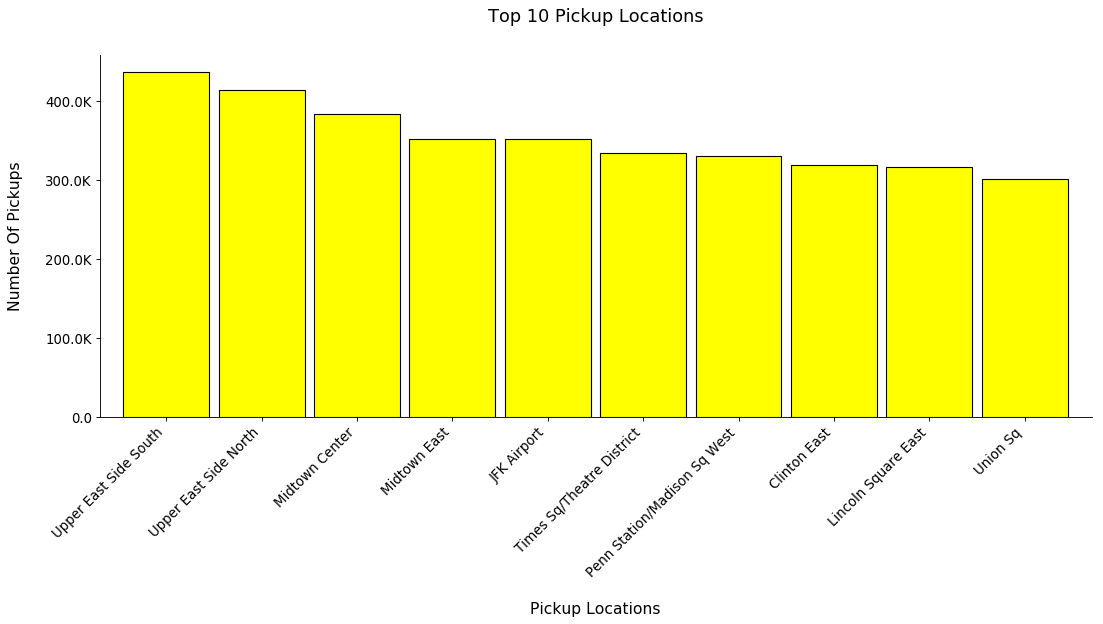

In [38]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80

topN = 10

# Extracting topN dropoff locations from TotalDODF Pandas DF
topN_per_location = (TotalPUDF.sort_values(by=["Total"], ascending=False)
                              .head(topN)
                              .loc[:, TotalDODF.columns != "Total"])

# Pulling out x and y vectors 
TotalPUDF.sort_values(by=["Total"], ascending=False).head()
x = topN_per_location["PUZone"]
y = topN_per_location[daysofweek].mean(axis=1) 
topN_mean_totals = pd.DataFrame(list(zip(x,y)), columns=["PUZone", "avg_daily"])

# Plotting DF
ax = topN_mean_totals.plot.bar(x="PUZone", 
                               y="avg_daily", 
                               figsize=(16,6), 
                               width=0.9, 
                               edgecolor="black", 
                               color="yellow")

# Setting Title, x, y label
ax.set_title(f"Top {topN} Pickup Locations", fontsize=16, pad=30)
ax.set_xlabel("Pickup Locations", fontsize=14)
ax.set_ylabel("Number Of Pickups", fontsize=14)

# Misc formatting
ax.yaxis.set_major_formatter(mkformatter)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

Not surprisingly most locations are in Manhattan downtown and at JFK Airport. We expect a similar turn-out for the dropoff locations. 

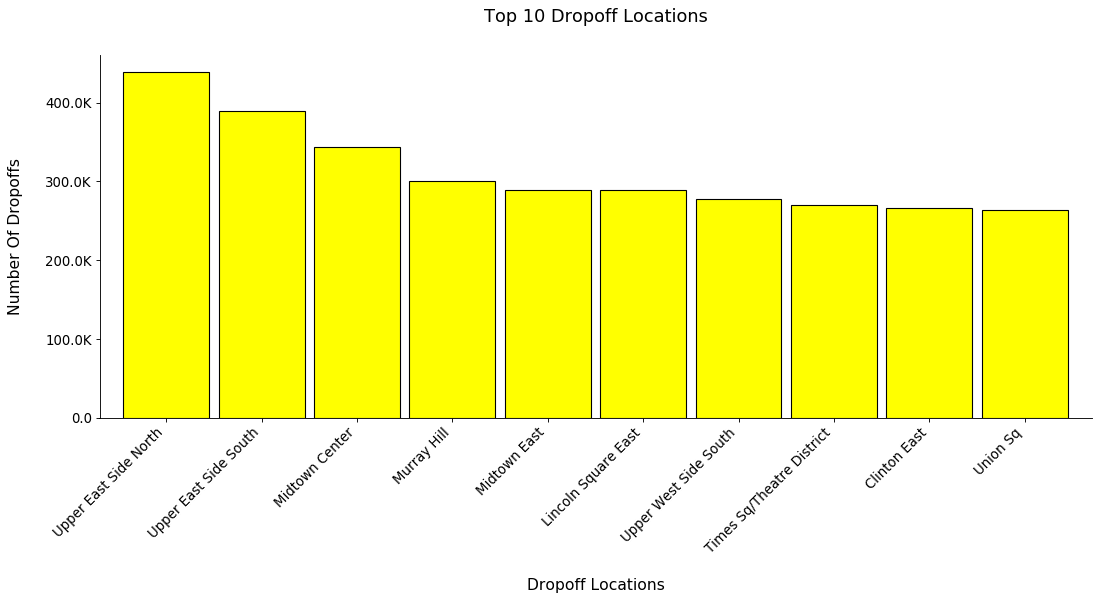

In [39]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80

topN = 10

# Extracting topN dropoff locations from TotalDODF Pandas DF
topN_per_location = (TotalDODF.sort_values(by=["Total"], ascending=False)
                              .head(topN)
                              .loc[:, TotalDODF.columns != "Total"])

# Pulling out x and y vectors 
TotalDODF.sort_values(by=["Total"], ascending=False).head()
x = topN_per_location["DOZone"]
y = topN_per_location[daysofweek].mean(axis=1) 
topN_mean_totals = pd.DataFrame(list(zip(x,y)), columns=["DOZone", "avg_daily"])

# Plotting DF
ax = topN_mean_totals.plot.bar(x="DOZone", 
                               y="avg_daily", 
                               figsize=(16,6), 
                               width=0.9, 
                               edgecolor="black", 
                               color="yellow")

# Setting Title, x, y label
ax.set_title(f"Top {topN} Dropoff Locations", fontsize=16, pad=30)
ax.set_xlabel("Dropoff Locations", fontsize=14)
ax.set_ylabel("Number Of Dropoffs", fontsize=14)

# Misc formatting
ax.yaxis.set_major_formatter(mkformatter)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

Indeed, downtown locations dominate the list where most daily dropoffs take place. However to our surprise JFK Airport is not on the list, in fact if we change the `topN` variable and rerun this cell it will not be in the top 20 either.

Our initial plan was to plot maps showing the average daily pickups for each location but we could not get this to work on TALC. When we were using our `classroom` environment where the required libraries were installed we could not instantiate our SPARK cluster, whereas on the standard `Python` environment of TALC the libraries we needed were not available nor could we install them. So we wrapped this cell into a try/except block for now.

In [40]:
%%capture

try:
    shapePath = os.path.join(CSV_DIR, "taxi_zones.shp")
    shapeDF  = gpd.read_file(shapePath)
    output_path = "./"
    busiest_dayofweek = TotalPUDF.iloc[1:, 2:].max().idxmax()
    bins = mc.FisherJenks(TotalPUDF[busiest_dayofweek]).bins
    filenames = []
    images = []

    for dayofweek  in ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]:
        #dayofweek = "Mon"
        bins = [10,50,100,1000,5000]
        shapeDF['hue'] = TotalPUDF[dayofweek]
        shapeDF = shapeDF.to_crs(epsg=3857)
        fig, ax = plt.subplots(1, figsize=(10, 6))
        ax.axis('off')
        plt.tight_layout()
        ax.set_title(f'Pickups on {dayofweek}'.rjust(30), fontdict={'fontsize': '24', 'fontweight': '6'}, loc='left')
        mp = shapeDF.plot(column='hue', cmap="Oranges", categorical=True, linewidth=0.6, edgecolor='0.2', alpha=0.7,
                          scheme="UserDefined", legend=True, classification_kwds={"bins": bins},
                          legend_kwds={'bbox_to_anchor': (0.34, 1), 'fontsize': 10, 'facecolor': 'white', 'framealpha': 0.9}, 
                          ax=ax)
        a = ctx.add_basemap(mp)

        plt.ioff()
        f = mp.get_figure()
        filename = os.path.join(output_path, dayofweek + '_Pickups.png')
        f.savefig(filename, dpi=80, bbox_inches='tight')
        filenames.append(filename)

    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('Pickups.gif', images, duration=1.5)
except:
    pass

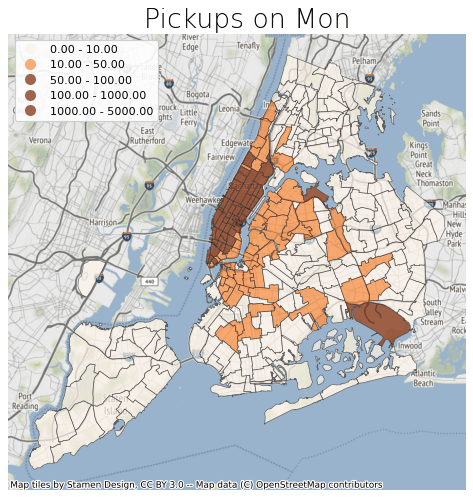

In [41]:
Image(filename="/home/szabolcs.szokoly/data608/Pickups.gif")

#### Q2. Do in-taxi payment systems differ in a way they calculate tip % based on Vendor ID?

Ben Wellington famous data story about how **How Software in Half of NYC Cabs Generates $5.2 Million a Year in Extra Tips** on his **I Quant NY** blog generated lot of discussions in the community. We wanted to check if the issue he discovered has been addressed since then. 

Reference:
https://iquantny.tumblr.com/post/107245431809/how-software-in-half-of-nyc-cabs-generates-52

First let's calculate the tip % in various ways from the fare related columns. We are only looking at the payment systems from Vendor 1, 2 and 4. For this purpose we use trip records where the `tip_amount` as not a round figure and where the `payment_type` was credit card since cash payments do not indicate `tip_amount`.

In [42]:
for VendorID in [1, 2, 4]:
    print(f"VendorID {VendorID}")
    display(taxiDF
          .filter(F.col("payment_type") == 1)
          .filter(F.col("tip_amount") != (F.col("tip_amount").cast(IntegerType())))
          .filter(F.col("VendorID") == VendorID)
          .filter(F.col("extra") > 0)
          .filter(F.col("mta_tax") > 0)
          .filter(F.col("tolls_amount") > 0)
          .filter(F.col("improvement_surcharge") > 0)
          .filter(F.col("congestion_surcharge") > 0)
          .withColumn("f", (F.col("tip_amount") / F.col("fare_amount"))
                           .cast(DecimalType(5, 3)))
          .withColumn("fe", (F.col("tip_amount") / (F.col("fare_amount") + 
                                                    F.col("extra")))
                           .cast(DecimalType(5, 3)))
          .withColumn("fem", (F.col("tip_amount") / (F.col("fare_amount") + 
                                                     F.col("extra") + 
                                                     F.col("mta_tax")))
                           .cast(DecimalType(5, 3)))
          .withColumn("femt", (F.col("tip_amount") / (F.col("fare_amount") + 
                                                      F.col("extra") + 
                                                      F.col("mta_tax") + 
                                                      F.col("tolls_amount")))
                           .cast(DecimalType(5, 3)))
          .withColumn("femti", (F.col("tip_amount") / (F.col("fare_amount") + 
                                                       F.col("extra") + 
                                                       F.col("mta_tax") + 
                                                       F.col("tolls_amount") + 
                                                       F.col("improvement_surcharge")))
                           .cast(DecimalType(5, 3)))
          .withColumn("femtic", (F.col("tip_amount") / (F.col("fare_amount") + 
                                                        F.col("extra") + 
                                                        F.col("mta_tax") + 
                                                        F.col("tolls_amount") + 
                                                        F.col("congestion_surcharge") + 
                                                        F.col("improvement_surcharge")))
                                .cast(DecimalType(5, 3)))
          .select("tip_amount", "fare_amount", "f", "fe", "fem", "femt", "femti", "femtic")
          .toPandas()
          .head())
    print()

VendorID 1


,tip_amount,fare_amount,f,fe,fem,femt,femti,femtic
0,12.25,52.0,0.236,0.225,0.223,0.200,0.199,0.192
1,12.25,52.0,0.236,0.225,0.223,0.200,0.199,0.192
2,12.20,39.5,0.309,0.290,0.287,0.251,0.249,0.237
3,8.15,31.5,0.259,0.240,0.236,0.201,0.199,0.188
4,12.25,52.0,0.236,0.225,0.223,0.200,0.199,0.192



VendorID 2


,tip_amount,fare_amount,f,fe,fem,femt,femti,femtic
0,8.71,34.0,0.256,0.252,0.249,0.214,0.212,0.200
1,6.81,24.5,0.278,0.272,0.267,0.218,0.216,0.200
2,7.11,26.0,0.273,0.268,0.263,0.217,0.215,0.200
3,5.78,29.0,0.199,0.196,0.193,0.162,0.160,0.150
4,6.61,23.5,0.281,0.275,0.270,0.218,0.216,0.200



VendorID 4


,tip_amount,fare_amount,f,fe,fem,femt,femti,femtic
0,13.11,52.0,0.252,0.232,0.230,0.209,0.208,0.200
1,13.18,52.0,0.253,0.233,0.231,0.209,0.208,0.200
2,10.88,44.0,0.247,0.242,0.239,0.211,0.210,0.200
3,19.78,52.0,0.380,0.350,0.347,0.313,0.312,0.300
4,6.98,25.0,0.279,0.274,0.268,0.217,0.215,0.200


From the output above we can speculate that the most likely scenario is that the in-taxi payment systems of Vendor 2 and 4 calculate the tip % differently from that of Vendor 1. In other words just like in 2013 riders do not seem to pay the same tip amount for the same milage across all yellow taxi types.

Let's add another column, `tip_pct` to the dataframe.

In [43]:
taxiDF = taxiDF.withColumn("tip_pct", F.when((F.col("VendorID") == 1), (F.col("tip_amount") / 
                                                                       (F.col("fare_amount") + 
                                                                        F.col("extra") + 
                                                                        F.col("mta_tax") + 
                                                                        F.col("tolls_amount") +  
                                                                        F.col("improvement_surcharge")))
                                                                        .cast(DecimalType(5, 2)))
                                                            .otherwise((F.col("tip_amount") / 
                                                                       (F.col("fare_amount") + 
                                                                        F.col("extra") + 
                                                                        F.col("mta_tax") + 
                                                                        F.col("tolls_amount") +  
                                                                        F.col("improvement_surcharge") +
                                                                        F.col("congestion_surcharge"))))
                                                                        .cast(DecimalType(5, 2)))

#### Q3. What  tip % riders give most often?

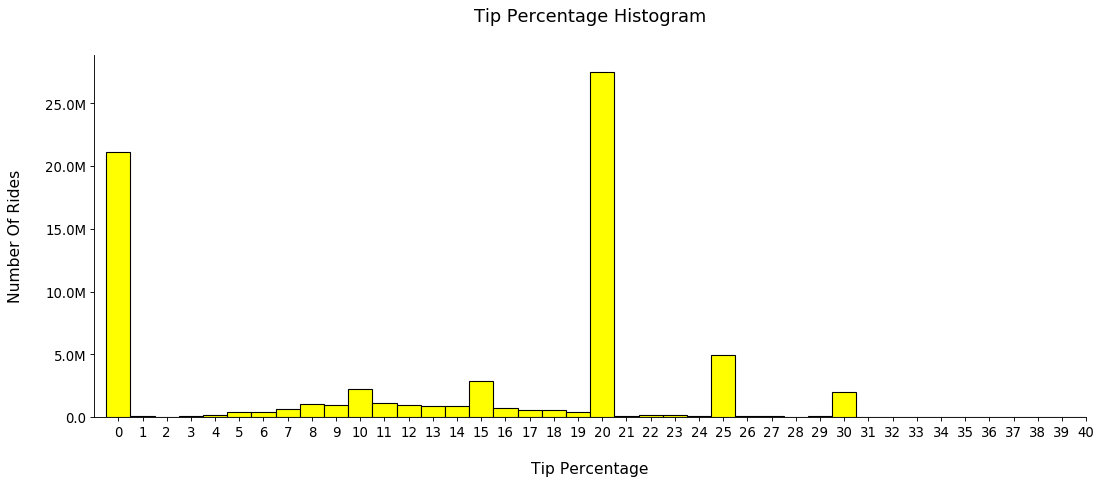

In [44]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80

# Extracting tip_pct from each ride from Spark DF to Pandas DF 
data = (taxiDF.select("tip_pct")
              .groupBy("tip_pct")
              .count()
              .orderBy("tip_pct")
              .withColumn("tip_pct", (F.col("tip_pct")*100).cast(IntegerType()))
              .toPandas())

# Plotting DF
ax = data.plot.bar(x="tip_pct", 
                   y="count", 
                   figsize=(16,6), 
                   width=1, 
                   edgecolor="black", 
                   color="yellow")

# Setting Title, x, y label
ax.set_title("Tip Percentage Histogram", fontsize=16, pad=30)
ax.set_xlabel("Tip Percentage", fontsize=14)
ax.set_ylabel("Number Of Rides", fontsize=14)

# Misc formatting
ax.yaxis.set_major_formatter(mkformatter)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.tick_params(axis="both", labelsize=12)
ax.set_xlim(-1, 40)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

The plot shows bumps at 20%, 25% and 30%, which are the default tip options on the credit card readers in cabs. A nice amount of rides give no tips, however the plot above include rides that concluded with cash payments as well for which we know the system does not register the `tip_amount` so we imagine most 0 tip % rides were truly 0 tip % rides at all.

#### Q4. Do riders tip more during pick hour or around certain periods of the day?

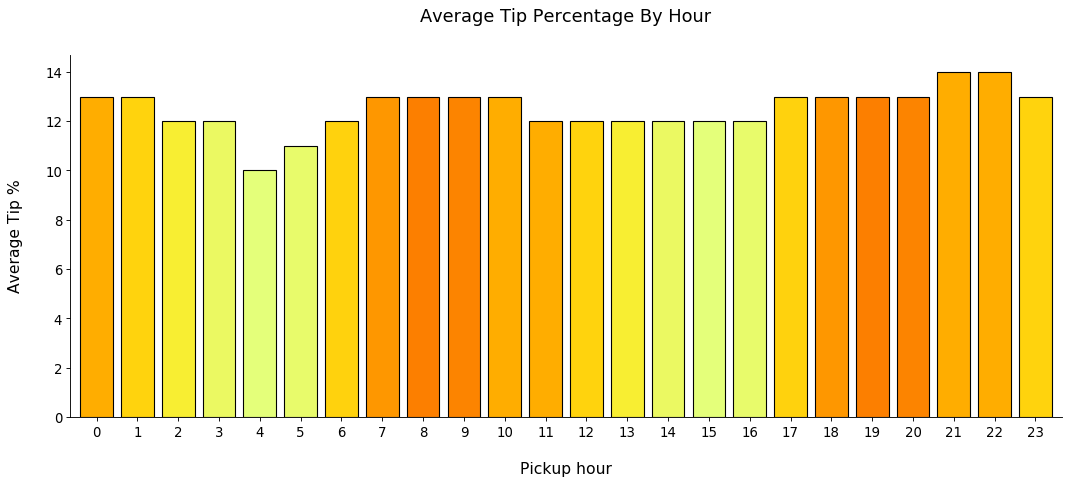

In [45]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80

# Extracting average tip_pct for each pickup hour from Spark DF to Pandas DF
data = (taxiDF.select("pickup_hour", "tip_pct")
             .groupBy("pickup_hour")
             .agg(F.avg("tip_pct"), F.count("pickup_hour"))
             .orderBy("pickup_hour")
             .withColumn("avg_tip_pct", (F.col("avg(tip_pct)")*100).cast(IntegerType()))
             .withColumn("counts", (F.col("count(pickup_hour)")).cast(IntegerType()))
             .drop("avg(tip_pct)", "count(pickup_hour)")
             .toPandas())

# Normalizing ride counts to use it for bar coloring
counts = data["counts"].head(topN)
min_cnt = np.min(counts)
max_cnt = np.max(counts)
tripCntNorm = [(cnt-min_cnt)/(max_cnt-min_cnt) for cnt in counts]
colors = [matplotlib.colors.rgb2hex(m) for m in cm.Wistia(tripCntNorm)]

# Plotting DF
ax = data.plot.bar(x="pickup_hour", 
                   y="avg_tip_pct", 
                   figsize=(16,6), 
                   width=0.8, 
                   edgecolor="black", 
                   color=colors)

# Setting Title, x, y label
ax.set_title('Average Tip Percentage By Hour', fontsize=16, pad=30)
ax.set_xlabel("Pickup hour", fontsize=14)
ax.set_ylabel("Average Tip %", fontsize=14)

# Misc formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

There seems to be no pattern in the tipping habit across the hours of a day although notably riders are less generous in earlier mornings between 4am-6am. The color of the bars give some indication on the distribution of trips across the hours without exact figures as the intention of this plot was to visualize difference in average tip % only.

#### Q5. Riders from which pickup Zone are likely to give more tip ?

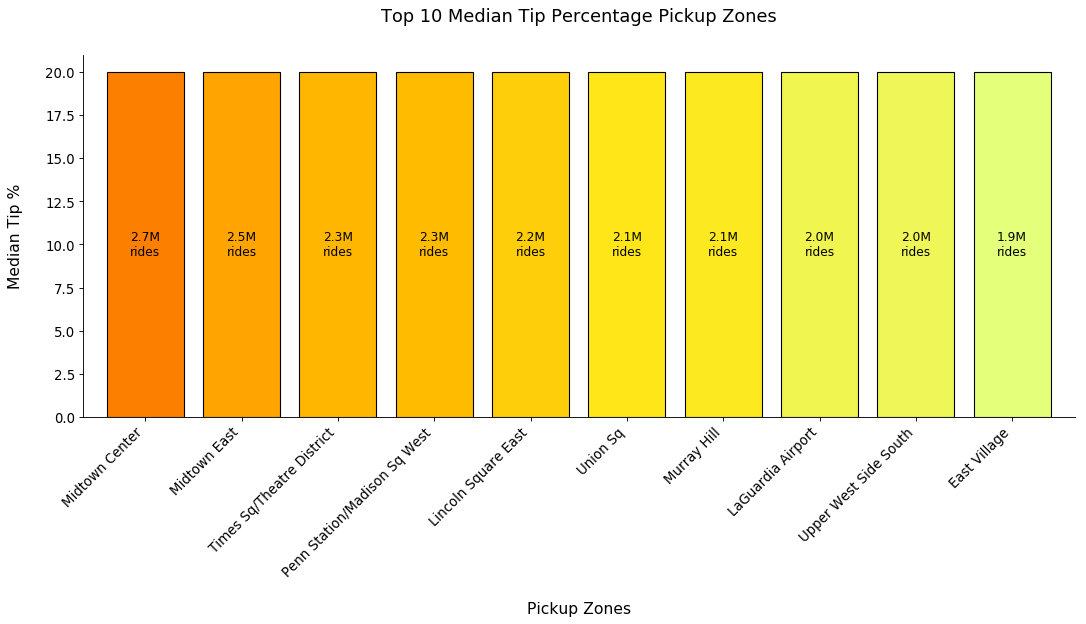

In [46]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80

topN = 10

# Oh, I love this, this is how you calculate median
grp_window = Window.partitionBy('PUZone')
magic_percentile = F.expr('percentile_approx(tip_pct, 0.5)')

# Extracting median tip_pct and ride count from Spark DF to Pandas DF
data = (taxiDF.select('PUZone', 'tip_pct')
              .groupBy('PUZone')
              .agg(magic_percentile.alias('median_tip_pct'), F.count("PUZone"))
              .withColumn("median_tip_pct", (F.col("median_tip_pct")*100).cast(IntegerType()))
              .withColumn("counts", (F.col("count(PUZone)")).cast(IntegerType()))
              .drop("count(PUZone)")
              .toPandas()
              .sort_values(by=["median_tip_pct", "counts"], ascending=False))

# Normalizing ride counts to use it for bar coloring
counts = data["counts"].head(topN)
min_cnt = np.min(counts)
max_cnt = np.max(counts)
tripCntNorm = [(cnt-min_cnt)/(max_cnt-min_cnt) for cnt in counts]
colors = [matplotlib.colors.rgb2hex(m) for m in cm.Wistia(tripCntNorm)]

# Plotting DF
ax = data.head(topN).plot.bar(x="PUZone", 
                              y="median_tip_pct", 
                              figsize=(16,6), 
                              width=0.8, 
                              edgecolor="black", 
                              color=colors)

# Formatting label that appears in the center of each bar
for i, v in enumerate(zip(data["median_tip_pct"].head(topN), data["counts"].head(topN))):
    ax.text(i, v[0]/2, mkfunc(int(v[1]), i)+"\nrides", 
            horizontalalignment="center", 
            verticalalignment="center", 
            fontsize=11)

# Setting Title, x, y label
ax.set_title(f"Top {topN} Median Tip Percentage Pickup Zones", fontsize=16, pad=30)
ax.set_xlabel("Pickup Zones", fontsize=14)
ax.set_ylabel("Median Tip %", fontsize=14)

# Misc formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

Now we see what our intuition also dictates which is that most often passengars using credit card for payment just accept the default 20% tip in the majority of trips regardless of the location. 

#### Q6. Does precipitation influence the number of rides?

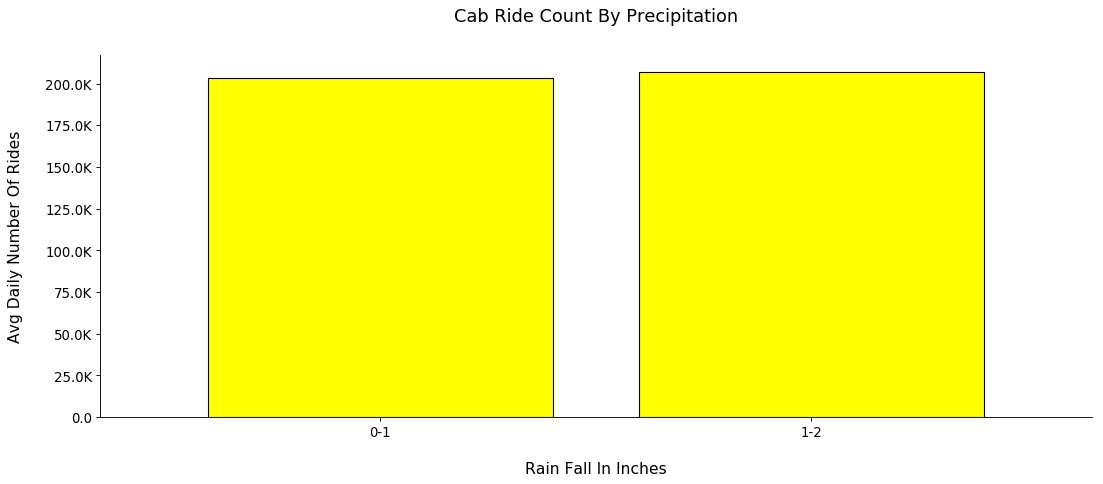

In [47]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80


binsize = 1 # in inch

# Creating bin to group rain_falls days
rain_max = weatherDF.agg({"rain_fall": "max"}).collect()[0][0]
bucketizer = Bucketizer(splits=np.arange(0, round((float(rain_max)+binsize)*2)/2, binsize),
                        inputCol='rain_fall', outputCol='rain_fall_range')

# Bucketizing days into rain_fall_ranges groups then to Pandas DF
df = taxiDF.select("pickup_dayofyear", "rain_fall")
df = bucketizer.transform(df)
data = (df.groupBy("pickup_dayofyear", "rain_fall_range")
          .count()
          .groupBy("rain_fall_range")
          .mean("count")
          .orderBy("rain_fall_range")
          .toPandas())
    
# Plotting DF
ax = data.plot.bar(x="rain_fall_range", 
                   y="avg(count)", 
                   figsize=(16,6), 
                   width=0.8, 
                   edgecolor="black", 
                   color="yellow")

# Formatting x-ticks labels
labels = [f"{int(float(item.get_text())*binsize)}-{int(float(item.get_text())*binsize+binsize)}" 
          for item in ax.get_xticklabels()]

# Setting Title, x, y label
ax.set_title("Cab Ride Count By Precipitation", fontsize=16, pad=30)
ax.set_xlabel("Rain Fall In Inches", fontsize=14)
ax.set_ylabel("Avg Daily Number Of Rides", fontsize=14)

# Misc formatting
ax.yaxis.set_major_formatter(mkformatter)
ax.set_xticklabels(labels, rotation = 0, ha="center")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

There appears to be no significant difference in the number of daily average trips based on `rain_fall`.

#### Q7. Does snow fall influence the number of rides?

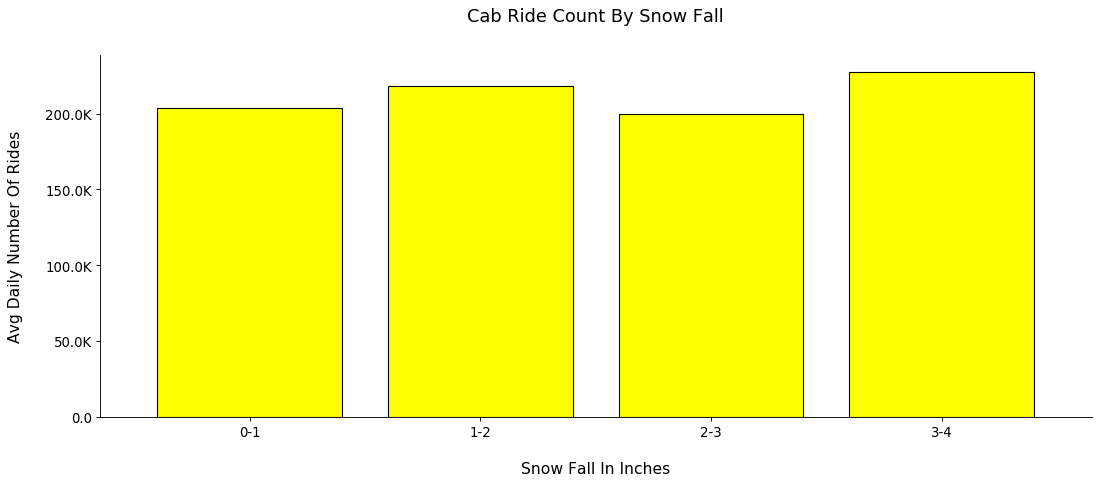

In [48]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80

binsize = 1 # in inch

# Creating bin to group snow_falls days
snow_max = weatherDF.agg({"snow_fall": "max"}).collect()[0][0]
bucketizer = Bucketizer(splits=np.arange(0, round((float(snow_max)+binsize)*2)/2, binsize),
                        inputCol='snow_fall', outputCol='snow_fall_range')

# Bucketizing days into snow_fall_ranges groups then to Pandas DF
df = taxiDF.select("pickup_dayofyear", "snow_fall")
df = bucketizer.transform(df)
data = (df.groupBy("pickup_dayofyear", "snow_fall_range")
          .count()
          .groupBy("snow_fall_range")
          .mean("count")
          .orderBy("snow_fall_range")
          .toPandas())
    
# Plotting DF
ax = data.plot.bar(x="snow_fall_range", 
                   y="avg(count)", 
                   figsize=(16,6), 
                   width=0.8, 
                   edgecolor="black", 
                   color="yellow")

# Formatting x-ticks labels
labels = [f"{int(float(item.get_text())*binsize)}-{int(float(item.get_text())*binsize+binsize)}" 
          for item in ax.get_xticklabels()]

# Setting Title, x, y label
ax.set_title("Cab Ride Count By Snow Fall", fontsize=16, pad=30)
ax.set_xlabel("Snow Fall In Inches", fontsize=14)
ax.set_ylabel("Avg Daily Number Of Rides", fontsize=14)

# Misc formatting
ax.yaxis.set_major_formatter(mkformatter)
ax.set_xticklabels(labels, rotation = 0, ha="center")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

Snow fall also does not seems to deter New Yorkers from using cabs or even encourage them to ride them more often during winter season which is not what we expected.

#### Q8. Does snow depth influence the number of rides?

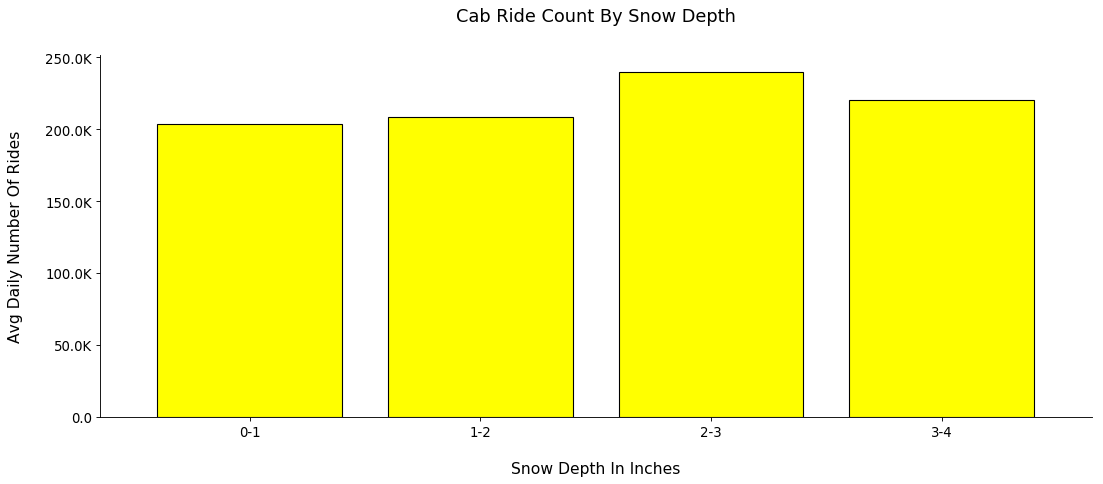

In [49]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80

binsize = 1 # in inch

# Creating bin to group snow_falls days
snow_depth = weatherDF.agg({"snow_depth": "max"}).collect()[0][0]
bucketizer = Bucketizer(splits=np.arange(0, round((float(snow_max)+binsize)*2)/2, binsize),
                        inputCol='snow_depth', outputCol='snow_depth_range')

# Bucketizing days into snow_fall_ranges groups then to Pandas DF
df = taxiDF.select("pickup_dayofyear", "snow_depth")
df = bucketizer.transform(df)
data = (df.groupBy("pickup_dayofyear", "snow_depth_range")
          .count()
          .groupBy("snow_depth_range")
          .mean("count")
          .orderBy("snow_depth_range")
          .toPandas())
    
# Plotting DF
ax = data.plot.bar(x="snow_depth_range", 
                   y="avg(count)", 
                   figsize=(16,6), 
                   width=0.8, 
                   edgecolor="black", 
                   color="yellow")

# Formatting x-ticks labels
labels = [f"{int(float(item.get_text())*binsize)}-{int(float(item.get_text())*binsize+binsize)}" 
          for item in ax.get_xticklabels()]

# Setting Title, x, y label
ax.set_title("Cab Ride Count By Snow Depth", fontsize=16, pad=30)
ax.set_xlabel("Snow Depth In Inches", fontsize=14)
ax.set_ylabel("Avg Daily Number Of Rides", fontsize=14)

# Misc formatting
ax.yaxis.set_major_formatter(mkformatter)
ax.set_xticklabels(labels, rotation = 0, ha="center")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

If we squint hard we may see a trend of somewhat elevated average trip count as the depth of snow increases.

#### Q9. Does temperature have influence on the number of rides?

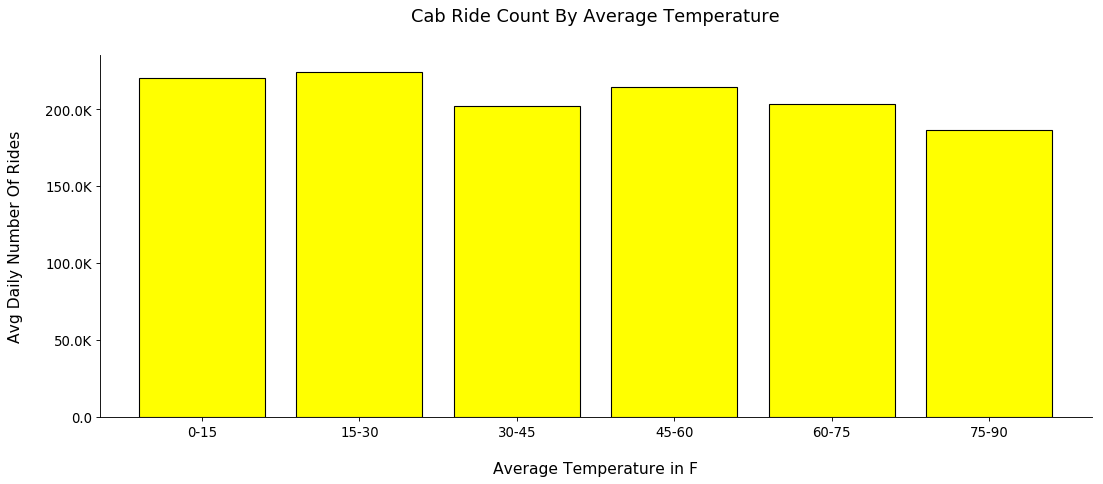

In [50]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80

binsize = 15 # in F

# Creating bin to group snow_falls days
avg_temp_max = weatherDF.agg({"avg_temperature": "max"}).collect()[0][0]
bucketizer = Bucketizer(splits=np.arange(0, round((float(avg_temp_max)+binsize)*2)/2, binsize),
                        inputCol='avg_temperature', outputCol='avg_temperature_range')

# Bucketizing days into snow_fall_ranges groups then to Pandas DF
df = taxiDF.select("pickup_dayofyear", "avg_temperature")
df = bucketizer.transform(df)
data = (df.groupBy("pickup_dayofyear", "avg_temperature_range")
          .count()
          .groupBy("avg_temperature_range")
          .mean("count")
          .orderBy("avg_temperature_range")
          .toPandas())
    
# Plotting DF
ax = data.plot.bar(x="avg_temperature_range", 
                   y="avg(count)", 
                   figsize=(16,6), 
                   width=0.8, 
                   edgecolor="black", 
                   color="yellow")

# Formatting x-ticks labels
labels = [f"{int(float(item.get_text())*binsize)}-{int(float(item.get_text())*binsize+binsize)}" 
          for item in ax.get_xticklabels()]

# Setting Title, x, y label
ax.set_title("Cab Ride Count By Average Temperature", fontsize=16, pad=30)
ax.set_xlabel("Average Temperature in F", fontsize=14)
ax.set_ylabel("Avg Daily Number Of Rides", fontsize=14)

# Misc formatting
ax.yaxis.set_major_formatter(mkformatter)
ax.set_xticklabels(labels, rotation = 0, ha="center")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

The difference is not huge but there is definitely a sign of less cab riders during warm season.

#### Q10. Does passenger count affect the tip %?

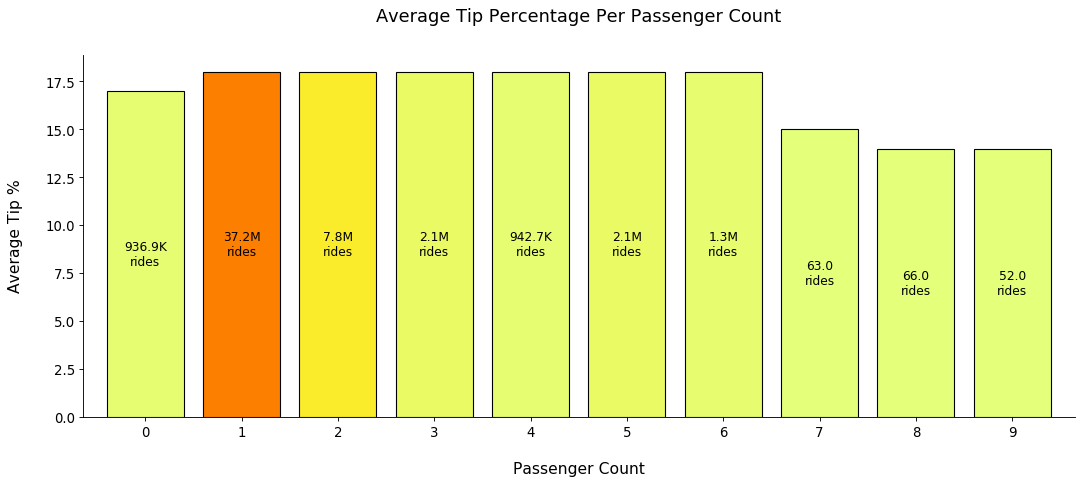

In [51]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80

# Extracting average tip_pct per passenger_count from Spark DF to Panda DF
data = (taxiDF.filter(F.col("payment_type") == 1)
              .select("passenger_count", "tip_pct")
              .groupBy("passenger_count")
              .agg(F.avg("tip_pct"), F.count("passenger_count"))
              .withColumn("avg_tip_pct", (F.col("avg(tip_pct)")*100).cast(IntegerType()))
              .withColumn("counts", (F.col("count(passenger_count)")).cast(IntegerType()))
              .drop("count(passenger_count)", "avg(tip_pct)")
              .orderBy("passenger_count")
              .toPandas())

# Normalizing ride counts to use it for bar coloring
counts = data["counts"].head(topN)
min_cnt = np.min(counts)
max_cnt = np.max(counts)
tripCntNorm = [(cnt-min_cnt)/(max_cnt-min_cnt) for cnt in counts]
colors = [matplotlib.colors.rgb2hex(m) for m in cm.Wistia(tripCntNorm)]

# Plotting DF
ax = data.head(topN).plot.bar(x="passenger_count", 
                              y="avg_tip_pct", 
                              figsize=(16,6), 
                              width=0.8, 
                              edgecolor="black", 
                              color=colors)

# Formatting label that appears in the center of each bar
for i, v in enumerate(zip(data["avg_tip_pct"].head(topN), data["counts"].head(topN))):
    ax.text(i, v[0]/2, mkfunc(int(v[1]), i)+"\nrides", 
            horizontalalignment="center", 
            verticalalignment="center", 
            fontsize=11)

# Setting Title, x, y label
ax.set_title(f"Average Tip Percentage Per Passenger Count", fontsize=16, pad=30)
ax.set_xlabel("Passenger Count", fontsize=14)
ax.set_ylabel("Average Tip %", fontsize=14)

# Misc formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

Passenger count is entered by the driver. Once again we have got a confirmation that passenger count also not a contributing factor in tip %.

#### Q11. Does RatecodeID have influence on the tip %?  

A ride can be in one of the 6 valid RatecodID groups at the end of the trip. These are:

* 1 = Standard rate
* 2 = JFK
* 3 = Newark 
* 4 = Nassau/Westchester 
* 5 = Negotiated fare
* 6 = Group ride

We would like to see if the average tip percentage is any different amongst these groups of rides.

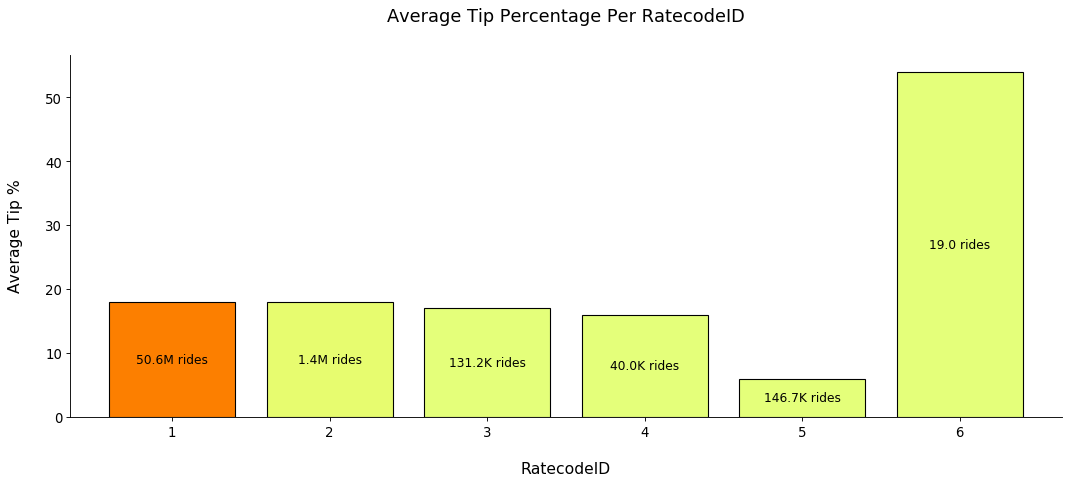

In [52]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80

# Exracting average tip_pct per RatecodeID from Spark DF to Panda DF
data = (taxiDF.filter(F.col("payment_type") == 1)
              .filter(F.col("RatecodeID") <= 6)
              .select("RatecodeID", "tip_pct")
              .groupBy("RatecodeID")
              .agg(F.avg("tip_pct"), F.count("RatecodeID"))
              .withColumn("avg_tip_pct", (F.col("avg(tip_pct)")*100).cast(IntegerType()))
              .withColumn("counts", (F.col("count(RatecodeID)")).cast(IntegerType()))
              .drop("count(RatecodeID)", "avg(tip_pct)")
              .orderBy("RatecodeID")
              .toPandas())


# Normalizing ride counts to use it for bar coloring
counts = data["counts"].head(topN)
min_cnt = np.min(counts)
max_cnt = np.max(counts)
tripCntNorm = [(cnt-min_cnt)/(max_cnt-min_cnt) for cnt in counts]
colors = [matplotlib.colors.rgb2hex(m) for m in cm.Wistia(tripCntNorm)]

# Plotting DF
ax = data.head(topN).plot.bar(x="RatecodeID", 
                              y="avg_tip_pct", 
                              figsize=(16,6), 
                              width=0.8, 
                              edgecolor="black", 
                              color=colors)

# Formatting label that appears in the center of each bar
for i, v in enumerate(zip(data["avg_tip_pct"].head(topN), data["counts"].head(topN))):
    ax.text(i, v[0]/2, mkfunc(int(v[1]), i)+" rides", 
            horizontalalignment="center", 
            verticalalignment="center", 
            fontsize=11)

# Setting Title, x, y label
ax.set_title(f"Average Tip Percentage Per RatecodeID", fontsize=16, pad=30)
ax.set_xlabel("RatecodeID", fontsize=14)
ax.set_ylabel("Average Tip %", fontsize=14)

# Misc formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

Outliers in RatecodeID makes the plot hard to read. We can certainly see that Negotiated Rate (5) and Group Ride (6) trips are different from the others, whereas rides of RatecodeID 1,2,3 and 4 are similar. Let's use median instead of average.

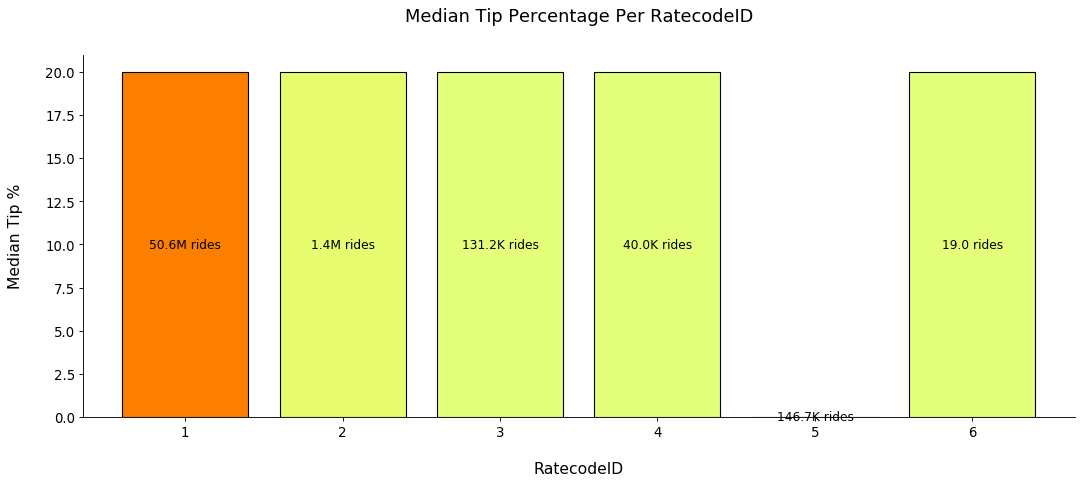

In [53]:
%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['figure.dpi'] = 80

# median calculator
grp_window = Window.partitionBy("RatecodeID")
magic_percentile = F.expr("percentile_approx(tip_pct, 0.5)")

# Extracting average tip_pct per RatecodeID from Spark DF to Panda DF
data = (taxiDF.filter(F.col("payment_type") == 1)
              .filter(F.col("RatecodeID") <= 6)
              .select("RatecodeID", "tip_pct")
              .groupBy("RatecodeID")
              .agg(magic_percentile.alias('median_tip_pct'), F.count("RatecodeID"))
              .withColumn("median_tip_pct", (F.col("median_tip_pct")*100).cast(IntegerType()))
              .withColumn("counts", (F.col("count(RatecodeID)")).cast(IntegerType()))
              .drop("count(RatecodeID)")
              .orderBy("RatecodeID")
              .toPandas())

# Normalizing ride counts to use it for bar coloring
counts = data["counts"].head(topN)
min_cnt = np.min(counts)
max_cnt = np.max(counts)
tripCntNorm = [(cnt-min_cnt)/(max_cnt-min_cnt) for cnt in counts]
colors = [matplotlib.colors.rgb2hex(m) for m in cm.Wistia(tripCntNorm)]

# Plotting DF
ax = data.head(topN).plot.bar(x="RatecodeID", 
                              y="median_tip_pct", 
                              figsize=(16,6), 
                              width=0.8, 
                              edgecolor="black", 
                              color=colors)

# Formatting label that appears in the center of each bar
for i, v in enumerate(zip(data["median_tip_pct"].head(topN), data["counts"].head(topN))):
    ax.text(i, v[0]/2, mkfunc(int(v[1]), i)+" rides", 
            horizontalalignment="center", 
            verticalalignment="center", 
            fontsize=11)

# Setting Title, x, y label
ax.set_title(f"Median Tip Percentage Per RatecodeID", fontsize=16, pad=30)
ax.set_xlabel("RatecodeID", fontsize=14)
ax.set_ylabel("Median Tip %", fontsize=14)

# Misc formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

The picture has not changed much, but we can reasonably suspect that Negotiated Fare rides which are paid by credit card hardly ever receive tip. On the other hand passengers of that few dozens of lifts in category 6 were more generous. We have arrived at the same conclusion that most taxi users do not mind giving 20% tip at the end of the journey regardless of the rating scheme applied.

#### Q12. Does trip distance have influence on tip %?

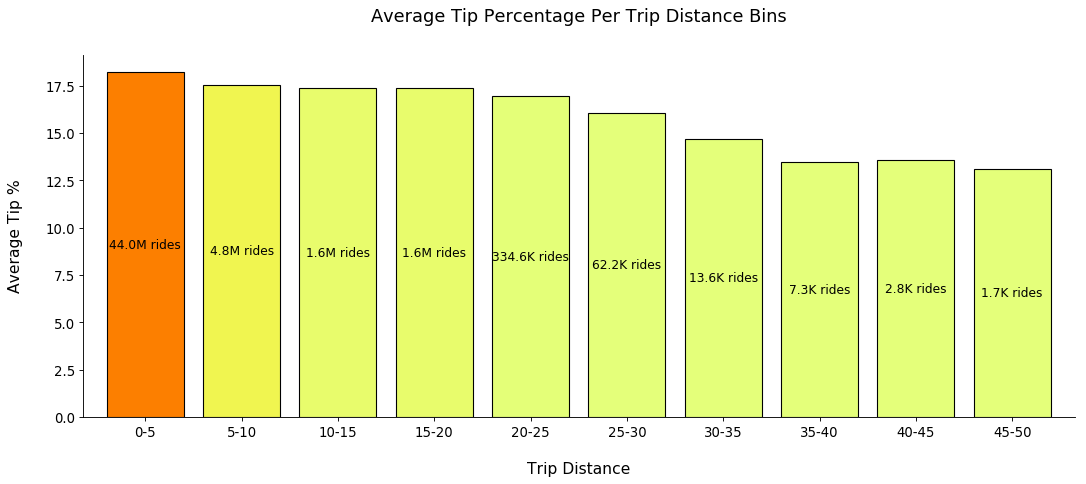

In [54]:
binsize = 5
max_distance = 50

# median calculator
grp_window = Window.partitionBy("trip_distance_range")
magic_percentile = F.expr("percentile_approx(tip_pct, 0.5)")

# Creating bins to group similar trip_distances trips
bucketizer = Bucketizer(splits=np.arange(0, round((float(max_distance)+binsize)*2)/2, binsize),
                        inputCol="trip_distance", outputCol="trip_distance_range")

# Bucketizing trip_distances into ranges then to Pandas DF
df = (taxiDF.filter(F.col("payment_type") == 1)
            .filter(F.col("trip_distance") > 0.05)
            .filter(F.col("trip_distance") < max_distance)
            .withColumn("tip_pct", (F.col("tip_pct")*100).cast(IntegerType()))
            .select("trip_distance", "tip_pct"))
df = bucketizer.transform(df)

# Extracting mean tip_pct per trip_distance_ranges from Scala DF to Panda DF
data = (df.groupBy("trip_distance_range")
          .agg(F.avg("tip_pct"), F.count("trip_distance_range"))
          .withColumnRenamed("avg(tip_pct)", "avg_tip_pct")
          .withColumnRenamed("count(trip_distance_range)", "counts")
          .orderBy("trip_distance_range")
          .toPandas())

# Normalizing ride counts to use it for bar coloring
counts = data["counts"]
min_cnt = np.min(counts)
max_cnt = np.max(counts)
tripCntNorm = [(cnt-min_cnt)/(max_cnt-min_cnt) for cnt in counts]
colors = [matplotlib.colors.rgb2hex(m) for m in cm.Wistia(tripCntNorm)]

# Plotting DF
ax = data.head(topN).plot.bar(x="trip_distance_range", 
                              y="avg_tip_pct", 
                              figsize=(16,6), 
                              width=0.8, 
                              edgecolor="black", 
                              color=colors)

# Formatting label that appears in the center of each bar
for i, v in enumerate(zip(data["avg_tip_pct"].head(topN), data["counts"].head(topN))):
    ax.text(i, v[0]/2, mkfunc2(int(v[1]), i)+" rides", 
            horizontalalignment="center", 
            verticalalignment="center", 
            fontsize=11)

# Formatting x-ticks labels
labels = [f"{int(float(item.get_text())*binsize)}-{int(float(item.get_text())*binsize+binsize)}" 
          for item in ax.get_xticklabels()]

# Setting Title, x, y label
ax.set_title(f"Average Tip Percentage Per Trip Distance Bins", fontsize=16, pad=30)
ax.set_xlabel("Trip Distance", fontsize=14)
ax.set_ylabel("Average Tip %", fontsize=14)

# Misc formatting
ax.yaxis.set_major_formatter(mkformatter)
ax.set_xticklabels(labels, rotation = 0, ha="center")
ax.tick_params(axis="both", labelsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend().set_visible(False)

So here we have a slight trend of diminishing tip % as the trip distance increases. It would be so nice to know how much tip cash payment rides received but we do not have that information.

### ML model

In the last part of our project we wanted to apply Machine Learning algorithm to our dataset to see how well we can predict the `fare_amount` from the other features of the dataset. For a baseline model we use a linear regression model. Our intuition dictates that with very few features we can builds a fairly good predictive model.
It is common knowledge that most taxi fare calculators need only the pickup and dropoff locations and the time of day. This is because the fare of the trip depends on how far the rider wants to go (distance) and under what traffic conditions (duration). There could be certain routes or destinations for which the taxi company has fix rates regardless of the where the trip begins or what the traffic conditions are, provided the destination is still within city or zone where the taxi company operates.

Our dataset already has the `trip_distance` and `trip_duration` features which directly related to distance and duration. We would like to see if these two features could give us enough predictive capacity, that is an **R^2** of at least 0.9. 

$$
 {fare\_amount}\ \thicksim {trip\_distance}, {trip\_duration\_sec}
$$

#### Preparation

In [55]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

NCORES = 16
features = ["trip_distance", "trip_duration_sec"]
labelCol = "fare_amount"

We begin by taking a sample from **taxiDF** as we do not require nor should we process 78 million trips for a pairplot. We only want to confirm our intuition that our two features are correlated with our dependant variable.

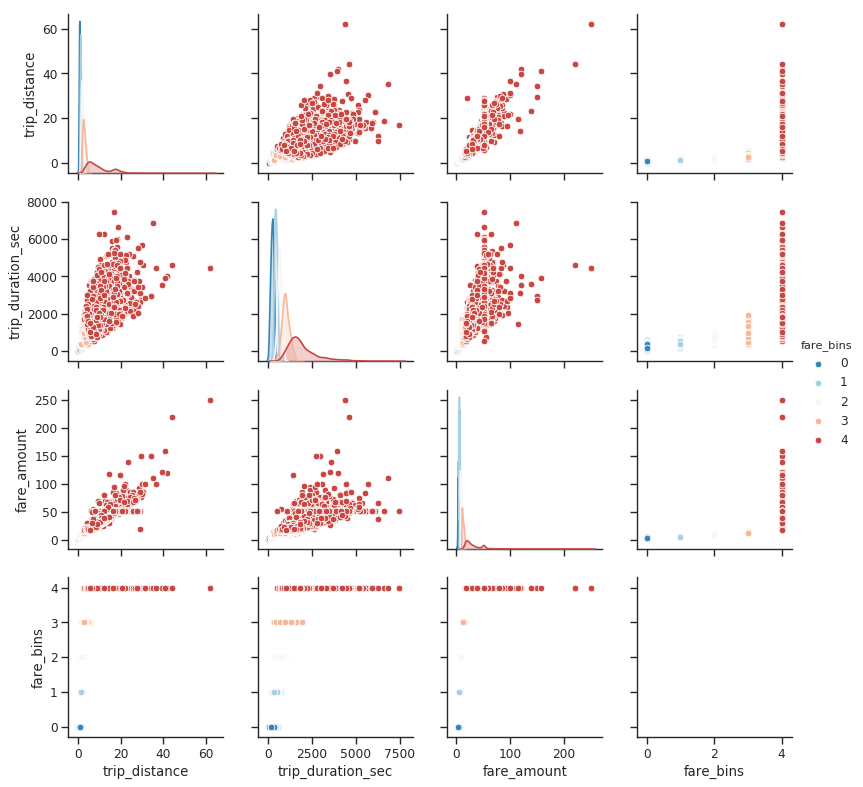

,trip_distance,trip_duration_sec,fare_amount,fare_bins
trip_distance,1.000000,0.825109,0.964671,0.667859
trip_duration_sec,0.825109,1.000000,0.879553,0.787824
fare_amount,0.964671,0.879553,1.000000,0.721917
fare_bins,0.667859,0.787824,0.721917,1.000000


In [56]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 80

sample_rows = 20000

# Taking a sample of the taxiDF
total_rows = taxiDF.count()
sampleDF = taxiDF.select(*features, labelCol).sample(False, sample_rows / total_rows)

# Converting the sample Spark DataFrame to Pandas DataFrame
samplePDF = sampleDF.toPandas()

# Binning the fare_amount into 5 quantiles
nbins = 5
samplePDF["fare_bins"] = pd.qcut(samplePDF["fare_amount"], q=nbins, labels=False)

# Plotting pairwise relationships in samplePDF
sns.set(style="ticks")
sns.pairplot(samplePDF, hue="fare_bins", palette="RdBu_r")
plt.show()

display(samplePDF.corr())

The `trip_distance` seems to be strongly correlated with `fare_amount` indeed. Let's see this relationship better on a scatter plot.

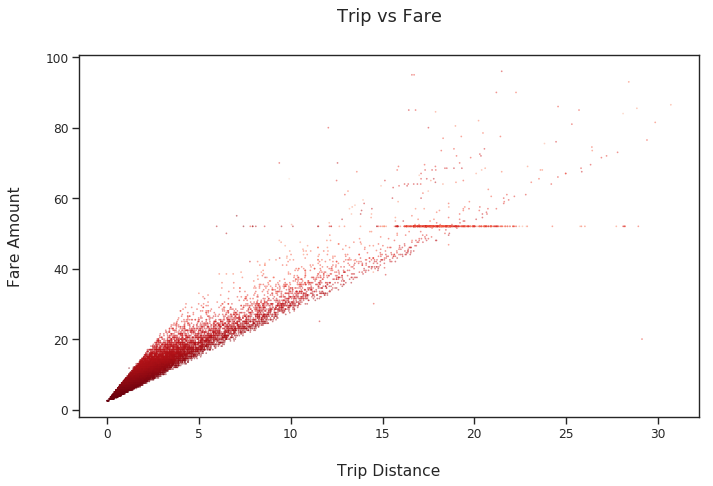

In [57]:
shorttripsDF = samplePDF[(samplePDF["fare_amount"] < 100) & (samplePDF["trip_distance"] < 40)]
trip_durations = shorttripsDF["trip_duration_sec"]
min_dur = np.max(trip_durations)
max_dur = np.min(trip_durations)
tripDurNorm = [(dur-min_dur)/(max_dur-min_dur) for dur in trip_durations]
colors = [matplotlib.colors.rgb2hex(m) for m in cm.Reds(tripDurNorm)]

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x=shorttripsDF["trip_distance"], 
           y=shorttripsDF["fare_amount"],
           c=colors,
           s=0.3, 
           alpha=0.5)
plt.title("Trip vs Fare", fontsize=16, pad=30)
plt.xlabel("Trip Distance", fontsize=14)
plt.ylabel("Fare Amount", fontsize=14)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
plt.show()

The linear relationship is fairly apparent but now it has become clear that there is another factor lurking in the background, marked by a horizontal line across the pane at around $53 dollars. Our two features may not be able to explain this line as that implies a constant `fare_amount` regardless of the `trip_distance`. We proceed with our model building anyway for now.

#### Building

We only have to independent features `trip_duration_sec` and `trip_distance` both of which are numerical. Consequently we do not require complex transformation pipelines to get a work model. We proceed without scaling the data which we will be doing in the second model.

In [58]:
sample_rows = 100000

# Taking a sample of the taxiDF
sampleDF = taxiDF.select(*features, labelCol).sample(False, sample_rows / total_rows).cache()
print("Sample size used for ML:", sampleDF.count())

# vectorize the features into a new column `features`
v_asm = VectorAssembler(inputCols=features, outputCol="features")
ml_taxiDF = v_asm.transform(sampleDF).cache()

# adjust repartitioning to match your data size...
print("Repartitioning")
print("\tPartitions before:", ml_taxiDF.rdd.getNumPartitions())
ml_taxiDF = ml_taxiDF.repartition(NCORES).cache()
_ = ml_taxiDF.count()
print("\tPartitions after: ", ml_taxiDF.rdd.getNumPartitions())

# Split the data into training and test sets (30% held out for testing)
print("Splitting dataset")
(trainingData, testData) = ml_taxiDF.randomSplit([0.7, 0.3])

# Train the model
print("Fitting\n")
lr = LinearRegression(featuresCol="features", labelCol=labelCol, maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(trainingData)

# Summary
print("\nModel Summary")
print("\tIntercept:    ", str(lr_model.intercept))
print("\tCoefficients: ", ", ".join((str(x) for x in lr_model.coefficients)))

trainingSummary = lr_model.summary
print("\nR^2   on training data: ", round(trainingSummary.r2, 4))
print("RMSE  on training data: ", round(trainingSummary.rootMeanSquaredError, 4))

Sample size used for ML: 100504
Repartitioning
	Partitions before: 200
	Partitions after:  16
Splitting dataset
Fitting


Model Summary
	Intercept:     2.9037679120692186
	Coefficients:  2.1478775546426636, 0.004063917070978154

R^2   on training data:  0.9531
RMSE  on training data:  2.5617


#### Predicting

In [59]:
lr_predictions0 = lr_model.transform(trainingData)
print("Predictions on training data")
display(lr_predictions0.select("prediction", "fare_amount", "features").sample(False, 0.001).toPandas().head(5))

lr_predictions = lr_model.transform(testData)
test_result = lr_model.evaluate(testData)
print("Predictions on test data")
display(lr_predictions.select("prediction", "fare_amount", "features").sample(False, 0.001).toPandas().head(5))

lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="fare_amount", metricName="r2")
print("R^2  on test data: ", round(lr_evaluator.evaluate(lr_predictions), 4))
print("RMSE on test data: ", round(test_result.rootMeanSquaredError, 4))

Predictions on training data


,prediction,fare_amount,features
0,5.722792,5.0,"[0.9, 218.0]"
1,6.136138,5.5,"[0.96, 288.0]"
2,8.687038,9.0,"[1.37, 699.0]"
3,9.538648,9.5,"[1.74, 713.0]"
4,4.356824,3.5,"[0.44, 125.0]"


Predictions on test data


,prediction,fare_amount,features
0,10.928480,12.0,"[1.88, 981.0]"
1,14.351215,14.5,"[3.15, 1152.0]"
2,13.773606,14.0,"[2.9, 1142.0]"
3,5.463355,5.0,"[0.52, 355.0]"
4,6.728844,6.0,"[1.2, 307.0]"


R^2  on test data:  0.9334
RMSE on test data:  3.2309


The model performs surprisingly well with 0.93 for **R^2** both test set. Let's see what it predicts for trips around $53.

In [ ]:
display(lr_predictions.filter(F.col("fare_amount").between(52, 54))
                      .select("prediction", "fare_amount", "features")
                      .sample(False, 0.001)
                      .toPandas()
                      .head(5))

#### Pipelining

Now we build a data processing pipeline, taking care of scaling the data as well. We proceed as follows:

* We put all features into a vector column.
* Since we are dealing with numerical data, we scale those features
* We pick the algorithm (in our case is Linear Regression)
* Finally we create the pipeline with the steps and in the order mentioned above

In [62]:
features = ["trip_distance", "trip_duration_sec"]

# Caching our sample DF, renaming our response variable to `label` which our Pipeline expects
ml_taxiDF2 = sampleDF.withColumnRenamed("fare_amount", "label").cache()

# Vectorizer to group features into a new column `unscaled_features`
vectorAssembler = VectorAssembler(inputCols=features, outputCol="unscaled_features")

# Scaler to scale features in the new `unscaled_features` column
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

# Linear regressor
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Pipeline
stages = [vectorAssembler, standardScaler, lr]
pipeline = Pipeline(stages=stages)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = ml_taxiDF2.randomSplit([0.3, 0.7])

lr_model2 = pipeline.fit(trainingData)
lr_prediction2 = lr_model2.transform(testData)

lr_prediction2.toPandas()[["prediction", "label", "unscaled_features"]].head(5)

,prediction,label,unscaled_features
0,3.435204,2.5,"[0.14, 35.0]"
1,3.822493,3.5,"[0.2, 116.0]"
2,3.830146,3.0,"[0.26, 70.0]"
3,4.399022,3.5,"[0.4, 147.0]"
4,4.554464,4.0,"[0.4, 199.0]"


####  Evaluation

In [63]:
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Summary
print("\nModel Summary")
print("\tIntercept:    ", str(lr_model2.stages[-1].intercept))
print("\tCoefficients: ", ", ".join((str(x) for x in lr_model2.stages[-1].coefficients)))

# R^2 - coefficient of determination
r2 = eval.evaluate(lr_prediction2, {eval.metricName: "r2"})
print(f"\nR^2  on test data: {r2:.4f}")

# Root Mean Square Error
rmse = eval.evaluate(lr_prediction2)
print(f"RMSE on test data: {rmse:.4f}")


Model Summary
	Intercept:     2.991876375127993
	Coefficients:  10.081750539466851, 2.181939921342841

R^2  on test data: 0.9568
RMSE on test data: 2.4416


#### Results of Linear Regression

Our Linear Regression model surpassed our target level of 0.9 once again. This model has 0.95 R^2, that is 95% of variability in our dependent variable `fare_amount` can be explained by our model, by our two independent variables. At the end of the day a taxi ride fare is fairy deterministic in nature and depends on really the distance you travel and the time you spend in taxi.

### Summary of Results

With this project, we aimed to answer the following questions:

1. What are the top pickup and dropoff locations?

2. Do the different vendors calculate tips differently?

3. What is the distribution of tip percentages? How do most people tip?

4. Does how much riders tip change with the time of day?

5. Does how much riders tip change with the pickup location?

6. Are the number of rides affected by precipitation?

7. Are the number of rides affected by snowfall?

8. Are the number of rides affected by snow depth?

9. Is there a relationship between temperature and number of rides?

10. Are tip percentages affected by number passenger?

11. Are tip percentages affected by RatecodeID?

12. Are tip percentages affected by the trip distance?

From the analyses, we arrived at the following results:

1. The top pickup locations include Upper East Side North and South, Midtown Center and East, Penn Station, Times Square and JFK Airport. Most top locations are within Manhattan, NYC's administrative and economic center. Zones within Manhattan, along with the zones at LaGuardia Airport and JFK Airport see the most pickups. We see a similar story with dropoff locations as pickup locations. Upper East Side, Midtown, Murray Hill, and Times Square are the top dropoff locations except JFK.

2. Vendors 2 and 4 include the congestion surcharge in the overall fare when calculating tip based on percentage. Vendor 1 does not. All vendors take into account the fare itself, extra charges, tolls, MTA tax, and improvement surcharges.

3. Most people tend to tip 20%, with the next most common tipping percentages being other multiples of 5 (10%, 15%, 25%, 30%). This is likely due to the credit card payment system setting these percentages as the default tipping options.

4. On average by hour, tips are about 12-13%. There is a notable dip in the early hours of morning between 4 am and 6 am.

5. Riders who were picked up at South Beach/Dongan Hills have the highest average tipping rate, followed by Newark Airport and Eltingville/Annadale/Prince's Bay. Notably, many of the highest tipping zones are either in Staten Island, or public parks in Queens or the Bronx. On the other hand the median tip percentage remains 20% at those locations as well.

6. There appears to be no appreciable difference in the average number of rides between days with none to minimal rain (0 to 1 inches), to those with moderate rain (1 to 2 inches).

7. Similar to rain, there's no discernable effect on the average number of daily rides of amount of snowfall.

8. The amount of snow on ground does seem to increase the number of New Yorkers who take cab to commute.

9. It appears that average daily taxi rides decrease with increasing average temperature, though this may be a product of the seasonal cycle of taxicab ride frequency.

10. Tip percentage is not affected by the number of passengers. Those very few rides with 7 or more passengers however did give less tip though than the vast majority.

11. Clients of Negotiated Fare rides (5) do not give tip, or at leat not through credit card payment. On the other hand passengers of Group ride (6) are more generous.

12. The tip amount decreases with increasing trip distance slighly.

We also attempted to train a regression model to predict the fare amount for a trip. As fare amount was found to be highly correlated with trip distance, despite a non-insignificant portion of rides having a flat amount of about $53 regardless of trip distance, we determined that a linear regression model should be sufficient to predict fare amount, based on trip distance and trip duration. Using these two independent variables, we achieved an R-squared value of 0.9 (90% of the variability of the data can be explained by the model). As we were aiming to achieve an R-squared value of 0.90 or greater, we can conclude that we can quite accurately predict what a trips's fare will be, knowing the distance traveled and time traveled for.

### References

* https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
* https://spark.apache.org
* https://runawayhorse001.github.io/LearningApacheSpark/pyspark.pdf
* https://w2.weather.gov/climate/xmacis.php?wfo=ok